In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from subgroups.utils.plotting import plot_scatter, plot_corr, plot_2D_embedding, plot_cat_continuous, plot_cat_proportions, spectral_no_yellow
from subgroups.datasets.registry import RosmapSingleCellDataset
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import SpectralClustering
from subgroups.utils.plotting import get_corr
from subgroups.utils.plotting import plot_2D_embedding
from subgroups.counterfactuals.counterfactuals import CounterfactualEvaluation

from subgroups.datasamplers.feature_selectors import SelectPCsBasic
from sklearn.manifold import SpectralEmbedding
from subgroups.models.classifier import XgbFactory
from sklearn.metrics import roc_auc_score
from subgroups.utils.random import fork_rng
from scipy.stats import chi2_contingency
import pandas as pd
from subgroups.datastorage.registry import gtex_subset_experiment_home
from matplotlib import ticker

from subgroups.utils.loading import load_eval_data, load_weights_data, find_files_with_suffix

In [2]:
experiment = gtex_subset_experiment_home()


Plotting SNR-results

In [2]:
path = '/Users/djuna/Documents/temp/results/gtex_subset_experiment_june_30/snr_outputs/combined_snr_outputs.npy'
snr_data = np.load(path)

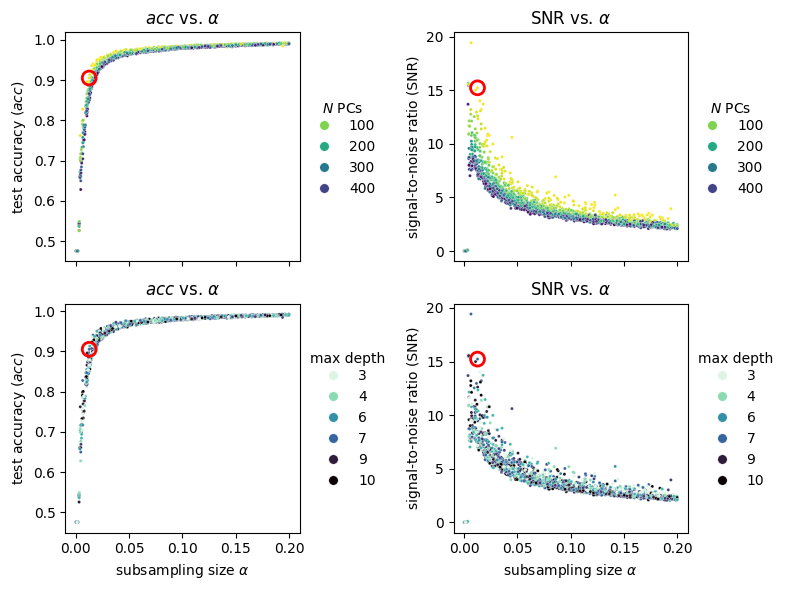

In [5]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(8, 6), sharex=True)
index = np.where(snr_data['snr_']>15)[0]
point1 = snr_data[index[snr_data[index]['test_accuracy_'].argmax()]]

plot_scatter(
    x=snr_data['alpha_'], 
    y=snr_data['test_accuracy_'], 
    hue=snr_data['n_pcs_'], 
    xlabel='subsampling size $\\alpha$', 
    ylabel='test accuracy ($acc$)', 
    title='$acc$ vs. $\\alpha$',
    legend_title='$N$ PCs',
    ax=axes[0,0],
    highlight_point=(point1['alpha_'], point1['test_accuracy_']),
    #highlight_point1=(point2['alpha_'], point2['test_accuracy_']),
    #highlight_point2=(point3['alpha_'], point3['test_accuracy_'])
)

plot_scatter(
    x=snr_data['alpha_'], 
    y=snr_data['snr_'], 
    hue=snr_data['n_pcs_'], 
    xlabel='subsampling size $\\alpha$', 
    ylabel='signal-to-noise ratio (SNR)', 
    title='SNR vs. $\\alpha$',
    legend_title='$N$ PCs',
    ax=axes[0,1],
    highlight_point=(point1['alpha_'], point1['snr_']),
    #highlight_point1=(point2['alpha_'], point2['snr_']),
    #highlight_point2=(point3['alpha_'], point3['snr_'])

)

plot_scatter(
    x=snr_data['alpha_'], 
    y=snr_data['test_accuracy_'], 
    hue=snr_data['max_depth_'], 
    xlabel='subsampling size $\\alpha$', 
    ylabel='test accuracy ($acc$)', 
    title='$acc$ vs. $\\alpha$',
    legend_title='max depth',
    ax=axes[1,0],
    cmap='mako_r',
    highlight_point=(point1['alpha_'], point1['test_accuracy_']),
    #highlight_point1=(point2['alpha_'], point2['test_accuracy_']),
    #highlight_point2=(point3['alpha_'], point3['test_accuracy_'])
)

plot_scatter(
    x=snr_data['alpha_'], 
    y=snr_data['snr_'], 
    hue=snr_data['max_depth_'], 
    xlabel='subsampling size $\\alpha$', 
    ylabel='signal-to-noise ratio (SNR)', 
    title='SNR vs. $\\alpha$',
    legend_title='max depth',
    ax=axes[1,1],
    cmap='mako_r',
    highlight_point=(point1['alpha_'], point1['snr_']),
    #highlight_point1=(point2['alpha_'], point2['snr_']),
    #highlight_point2=(point3['alpha_'], point3['snr_'])
)

plt.tight_layout()
plt.savefig('/Users/djuna/Documents/Maydell-MIT-PhD-Thesis/MIT-thesis-template/ch4_figs/gtex_subset_experiment_june_30.png', dpi=300)


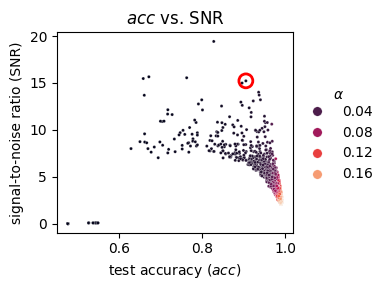

In [7]:
plot_scatter(
    x=snr_data['test_accuracy_'], 
    y=snr_data['snr_'], 
    hue=snr_data['alpha_'], 
    xlabel='test accuracy ($acc$)', 
    ylabel='signal-to-noise ratio (SNR)', 
    title='$acc$ vs. SNR',
    legend_title='$\\alpha$',
    cmap='rocket',
    highlight_point=(point1['test_accuracy_'], point1['snr_']),
    #highlight_point1=(point2['test_accuracy_'], point2['snr_']),
    #highlight_point2=(point3['test_accuracy_'], point3['snr_'])
)

plt.tight_layout()
plt.savefig('/Users/djuna/Documents/Maydell-MIT-PhD-Thesis/MIT-thesis-template/ch4_figs/acc_vs_snr_gtex_subset_experiment_june_30.png', dpi=300)


plot embeddings

In [3]:
path = '/Users/djuna/Documents/temp/results/gtex_subset_experiment_june_30/datamodel_outputs/'


Text(0.8637819886207581, 266.49, '0.75 ± 0.07')

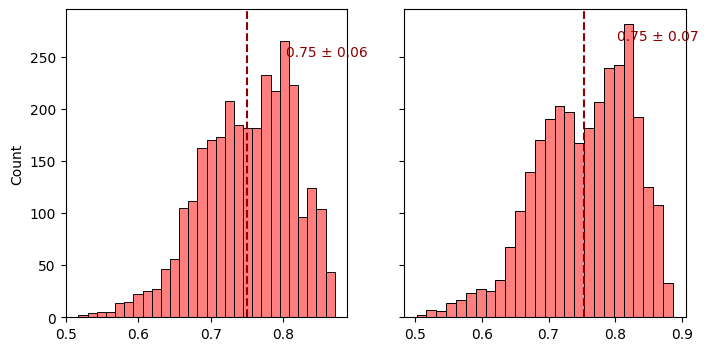

In [4]:

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

# --- Pearson plot ---
x = load_eval_data(path, 'pearson_correlations')[0]
x = x[x!=0]
ax = axes[0]
mean1 = np.mean(x)
std1 = np.std(x)
sns.histplot(x, color='red', alpha=0.5, ax=ax, label=r'$\alpha \approx 0.03$')
ax.axvline(x=mean1, color='darkred', linestyle='--')
ax.text(mean1 + 0.11, ax.get_ylim()[1] * 0.9, f'{mean1:.2f} ± {std1:.2f}', color='darkred', ha='center')

x = load_eval_data(path, 'spearman_correlations')[0]
x = x[x!=0]
ax = axes[1]
mean1 = np.mean(x)
std1 = np.std(x)
sns.histplot(x, color='red', alpha=0.5, ax=ax, label=r'$\alpha \approx 0.03$')
ax.axvline(x=mean1, color='darkred', linestyle='--')
ax.text(mean1 + 0.11, ax.get_ylim()[1] * 0.9, f'{mean1:.2f} ± {std1:.2f}', color='darkred', ha='center')


In [5]:
weights, batch_number = load_weights_data(path)
x = load_eval_data(path, 'pearson_correlations')[0]
weights = weights[x!=0]
index_grp_1 = (experiment.dataset.coarse_labels)
index_grp_2 = np.invert(index_grp_1)

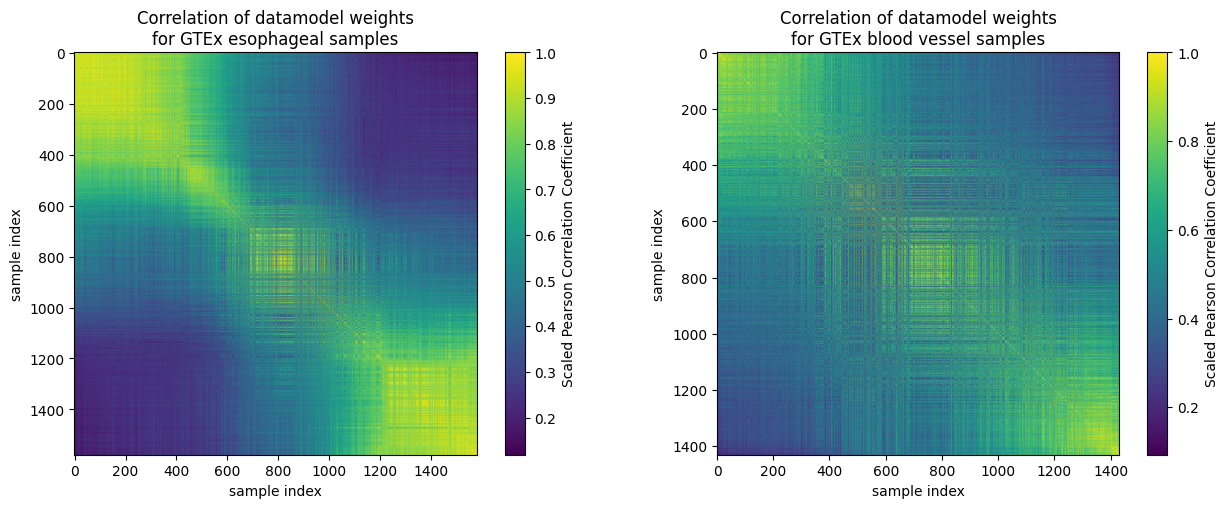

In [6]:

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

plot_corr(weights, index_grp_1, 'Correlation of datamodel weights\nfor GTEx esophageal samples', ax=axes[0], fig=fig)
plot_corr(weights, index_grp_2, 'Correlation of datamodel weights\nfor GTEx blood vessel samples', ax=axes[1], fig=fig)
plt.tight_layout()
plt.savefig('/Users/djuna/Documents/Maydell-MIT-PhD-Thesis/MIT-thesis-template/ch4_figs/gtex_subset_corr.png', dpi=300)



In [253]:
# experiment = gtex_subset_experiment_home()
# corr = np.load('/Users/djuna/Documents/temp/results/gtex_subset_experiment_prev/datamodel_outputs/batch_11_correlations.npy')
# weights = np.load('/Users/djuna/Documents/temp/results/gtex_subset_experiment_prev/datamodel_outputs/batch_11_weights.npy')
# index_grp_1 = (experiment.dataset.coarse_labels)
# index_grp_2 = np.invert(index_grp_1)

plot ground-truth subgroup labels

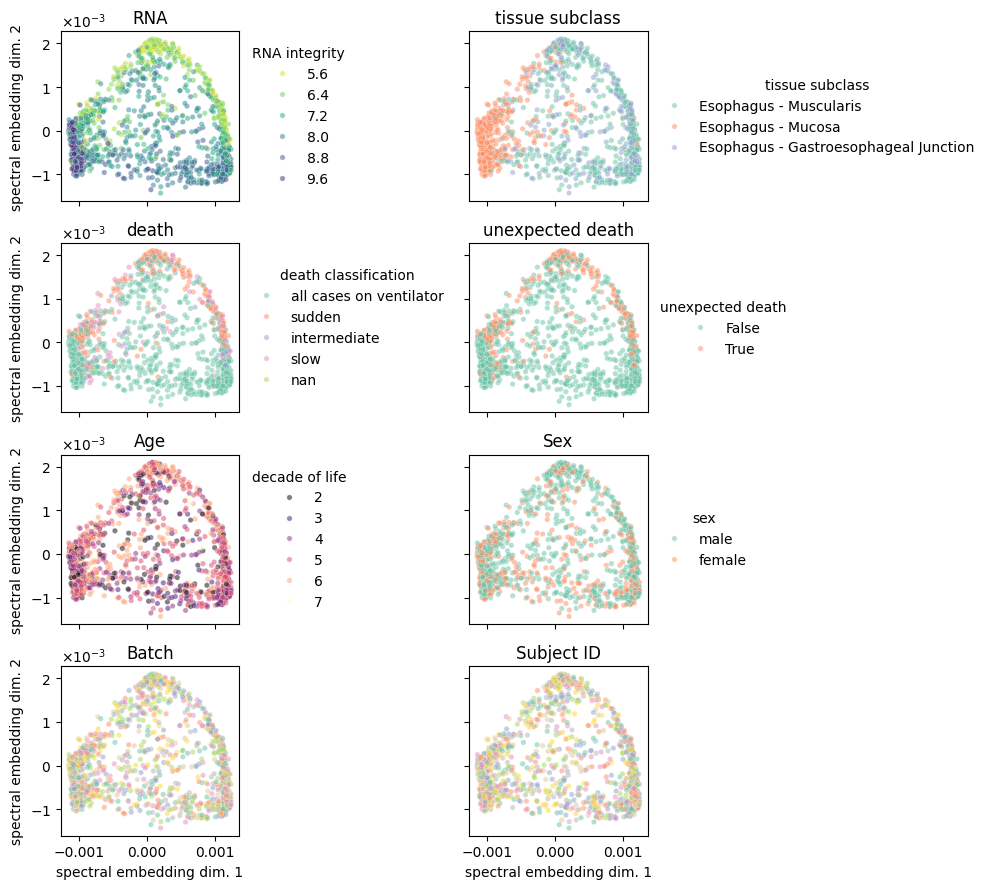

In [7]:
ages = np.unique(experiment.dataset.descriptive_data['AGE'])
conversion = [2, 3, 4, 5, 6, 7]
dictionary = dict(zip(ages, conversion))
ages = np.array([dictionary[age] for age in experiment.dataset.descriptive_data['AGE']])
unexpected_deaths = np.array([x in set([1,2,3]) for x in experiment.dataset.descriptive_data['DTHHRDY']])
dictionary = {2: 'female', 1: 'male'}
sex = np.array([dictionary[sex] for sex in experiment.dataset.descriptive_data['SEX']])
d_dict = {'1.0': 'sudden', '2.0': 'sudden', '3.0': 'intermediate', '4.0': 'slow', '0.0': 'all cases on ventilator', 'nan': 'nan'}
death_classification = np.array([d_dict[x] for x in experiment.dataset.descriptive_data['DTHHRDY'].astype(str)])


fig, axes = plt.subplots(4, 2, figsize=(10, 9), sharey=True, sharex=True)

plot_2D_embedding(weights, index_grp_1, experiment.dataset.descriptive_data['SMRIN'][(index_grp_1)], 'RNA', 'RNA integrity', 'viridis_r', ax=axes[0,0], s=15, alpha=0.5)
plot_2D_embedding(weights, index_grp_1, experiment.dataset.descriptive_data['SMTSD'][(index_grp_1)], 'tissue subclass', 'tissue subclass', 'Set2', ax=axes[0,1], s=15, alpha=0.5)
plot_2D_embedding(weights, index_grp_1, death_classification[(index_grp_1)], 'death', 'death classification', 'Set2', ax=axes[1,0], s=15, alpha=0.5)
plot_2D_embedding(weights, index_grp_1, unexpected_deaths[(index_grp_1)], 'unexpected death', 'unexpected death', 'Set2', ax=axes[1,1], s=15, alpha=0.5)

plot_2D_embedding(weights, index_grp_1, ages[(index_grp_1)], 'Age', 'decade of life', 'magma', ax=axes[2,0], s=15, alpha=0.5)
plot_2D_embedding(weights, index_grp_1, sex[(index_grp_1)], 'Sex', 'sex', 'Set2', ax=axes[2,1], s=15, alpha=0.5)
plot_2D_embedding(weights, index_grp_1, experiment.dataset.descriptive_data['SMNABTCH'][(index_grp_1)], 'Batch', 'RNA extraction batch', 'Set2', ax=axes[3,0], s=15, show_legend=False, alpha=0.5)
plot_2D_embedding(weights, index_grp_1, experiment.dataset.descriptive_data['SUBJID'][(index_grp_1)], 'Subject ID', 'subject ID', 'Set2', ax=axes[3,1], s=15, show_legend=False, alpha=0.5)

axes[0,1].yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
axes[0,1].ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

plt.tight_layout()
plt.savefig('/Users/djuna/Documents/Maydell-MIT-PhD-Thesis/MIT-thesis-template/ch4_figs/gtex_subset_spectral_embedding_explaining_labels.png', dpi=300)


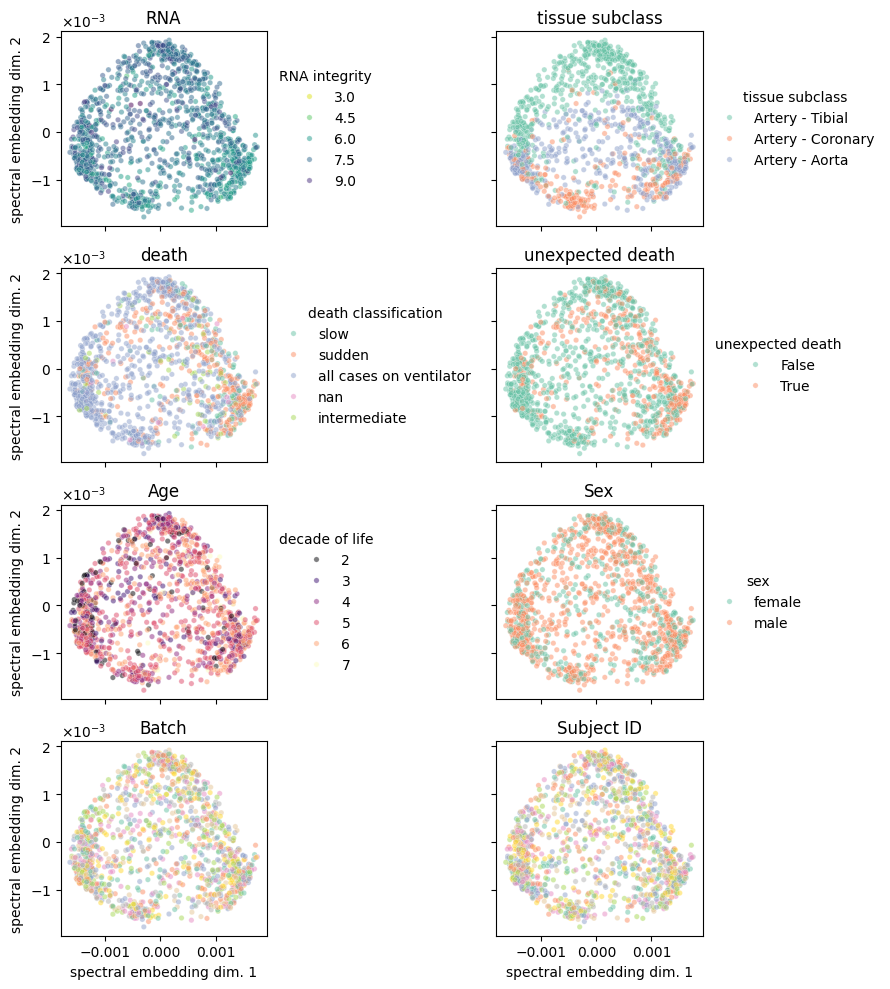

In [8]:
ages = np.unique(experiment.dataset.descriptive_data['AGE'])
conversion = [2, 3, 4, 5, 6, 7]
dictionary = dict(zip(ages, conversion))
ages = np.array([dictionary[age] for age in experiment.dataset.descriptive_data['AGE']])
unexpected_deaths = np.array([x in set([1,2,3]) for x in experiment.dataset.descriptive_data['DTHHRDY']])
dictionary = {2: 'female', 1: 'male'}
sex = np.array([dictionary[sex] for sex in experiment.dataset.descriptive_data['SEX']])
d_dict = {'1.0': 'sudden', '2.0': 'sudden', '3.0': 'intermediate', '4.0': 'slow', '0.0': 'all cases on ventilator', 'nan': 'nan'}
death_classification = np.array([d_dict[x] for x in experiment.dataset.descriptive_data['DTHHRDY'].astype(str)])


fig, axes = plt.subplots(4, 2, figsize=(9, 10), sharey=True, sharex=True)

plot_2D_embedding(weights, index_grp_2, experiment.dataset.descriptive_data['SMRIN'][(index_grp_2)], 'RNA', 'RNA integrity', 'viridis_r', ax=axes[0,0], s=15, alpha=0.5)
plot_2D_embedding(weights, index_grp_2, experiment.dataset.descriptive_data['SMTSD'][(index_grp_2)], 'tissue subclass', 'tissue subclass', 'Set2', ax=axes[0,1], s=15, alpha=0.5)
plot_2D_embedding(weights, index_grp_2, death_classification[(index_grp_2)], 'death', 'death classification', 'Set2', ax=axes[1,0], s=15, alpha=0.5)
plot_2D_embedding(weights, index_grp_2, unexpected_deaths[(index_grp_2)], 'unexpected death', 'unexpected death', 'Set2', ax=axes[1,1], s=15, alpha=0.5)

plot_2D_embedding(weights, index_grp_2, ages[(index_grp_2)], 'Age', 'decade of life', 'magma', ax=axes[2,0], s=15, alpha=0.5)
plot_2D_embedding(weights, index_grp_2, sex[(index_grp_2)], 'Sex', 'sex', 'Set2', ax=axes[2,1], s=15, alpha=0.5)
plot_2D_embedding(weights, index_grp_2, experiment.dataset.descriptive_data['SMNABTCH'][(index_grp_2)], 'Batch', 'RNA extraction batch', 'Set2', ax=axes[3,0], s=15, show_legend=False, alpha=0.5)
plot_2D_embedding(weights, index_grp_2, experiment.dataset.descriptive_data['SUBJID'][(index_grp_2)], 'Subject ID', 'subject ID', 'Set2', ax=axes[3,1], s=15, show_legend=False, alpha=0.5)

axes[0,1].yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
axes[0,1].ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

plt.tight_layout()
plt.savefig('/Users/djuna/Documents/Maydell-MIT-PhD-Thesis/MIT-thesis-template/ch4_figs/gtex_subset_spectral_embedding_explaining_labels_artery.png', dpi=300)


Counterfactual experiment

In [10]:
from subgroups.utils.counterfactual_plotting import extract_group_data, extract_auc_diffs, plot_auc_diffs
path = '/Users/djuna/Documents/temp/results/gtex_subset_experiment_june_30/clustering_outputs/'

- Have to plot baseline as well 

-- with same n_train & n_test size of 10

-- and with larger n_train & n_test size

-- add undersampler to test split too

-- plot both on AUC1 and on AUC2 

- Add the additional cluster seeds


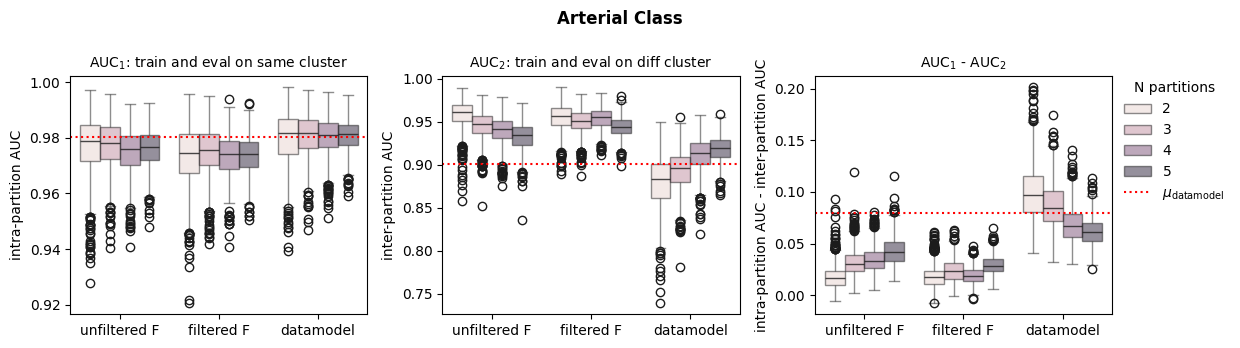

In [11]:
all_data = extract_group_data(path, 2)
df_wide = extract_auc_diffs(all_data)

plot_auc_diffs(all_data, df_wide, 'Arterial Class')

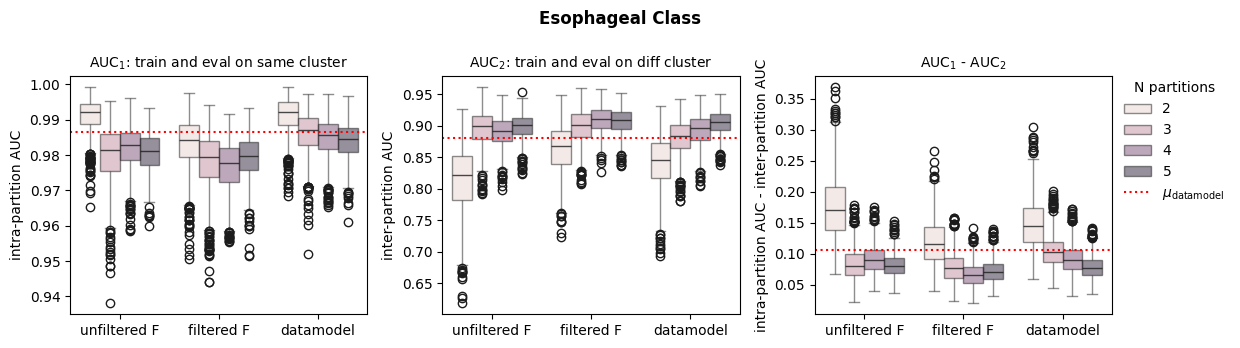

In [12]:
all_data = extract_group_data(path, 1)
df_wide = extract_auc_diffs(all_data)

plot_auc_diffs(all_data, df_wide, 'Esophageal Class')

In [ ]:
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn import set_config
from tqdm import tqdm
from subgroups.utils.scoring import compute_margins

#set_config(display='text')

n_iter = 10
all_aucs = []
all_margins = []
for i in tqdm(range(n_iter)):
    children = fork_rng(np.random.default_rng(i), 3)

    X_tr, X_te, y_tr, y_te = train_test_split(
        experiment.dataset.features[:,pc_indices], np.invert(experiment.dataset.coarse_labels),
        train_size=0.012507530044163674,
        #stratify=np.invert(experiment.dataset.coarse_labels),        # <-- ensures y’s class distribution is preserved
        shuffle=True,
        random_state=np.random.RandomState(children[0].bit_generator)
    )

    rus = RandomUnderSampler(random_state=np.random.RandomState(children[1].bit_generator))
    X_tr_bal, y_tr_bal = rus.fit_resample(X_tr, y_tr)

    model = XgbFactory(max_depth=7).build_model(rng=np.random.default_rng(children[2]))
    model.fit(X_tr_bal, y_tr_bal)
    pred = model.predict_proba(X_te) # must also random undersample here
    auc = roc_auc_score(y_te, pred[:,1])
    margins = compute_margins(pred[:,1], y_te)
    all_aucs.append(auc)
    all_margins.append(np.mean(margins))

res_baseline = pd.DataFrame(np.hstack(all_aucs), columns = ['mean_auc'])
res_baseline['type'] = 'baseline'
res_baseline['seed'] = np.arange(len(res_baseline))
res_baseline['prob_type'] = 'not applicable'
res_baseline['mean_margins'] = np.hstack(all_margins)

## below is scrap

<>:29: SyntaxWarning: invalid escape sequence '\m'
<>:29: SyntaxWarning: invalid escape sequence '\m'
/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_18683/4088265622.py:29: SyntaxWarning: invalid escape sequence '\m'
  axes[i].axhline(val, linestyle=':', label=f'$\mu_{'datamodel'}$', color='red')


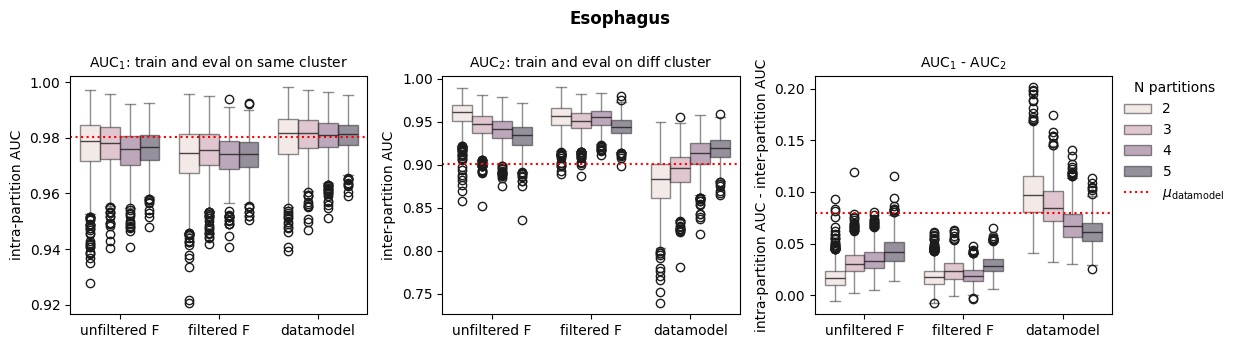

In [116]:

fig, axes = plt.subplots(1, 3, figsize=(12.5, 3.5), sharey=False, sharex=False)

for i, name in enumerate(['evaluation_on_split','evaluation_outside_split']):
    data_subset = all_data[all_data['prob_type']==name]
    plot_cat_continuous(
            data=data_subset,
            cat_col='input',
            cont_col='mean_auc',
            test=None,
            text_format='full',
            hue = 'nclusters',
            #palette=['grey', 'blue', 'blue'],
            ax=axes[i],
            #y_lower=0.8,
            #y_upper=1.2,
            loc='outside',
            boxplot_kwargs={
                'boxprops':     {'alpha': 0.5},
                'whiskerprops': {'alpha': 0.5},
                'capprops':     {'alpha': 0.5},
                'medianprops':  {'alpha': 0.8},
                'width': 0.8
            },
            order = ['unfiltered F', 'filtered F', 'datamodel'],
            stripplot_kwargs={'alpha': 0.6, 'size': 0}
        )
    
    val = data_subset[data_subset['input']=='datamodel']['mean_auc'].mean()
    axes[i].axhline(val, linestyle=':', label=f'$\mu_{'datamodel'}$', color='red')
    axes[i].get_legend().remove()
  

plot_cat_continuous(
        data=df_wide,
        cat_col='input',
        cont_col='mean_auc_diff',
        test=None,
        text_format='full',
        hue = 'nclusters',
        #palette=['grey', 'blue', 'blue'],
        ax=axes[2],
        loc='outside',
        boxplot_kwargs={
            'boxprops':     {'alpha': 0.5},
            'whiskerprops': {'alpha': 0.5},
            'capprops':     {'alpha': 0.5},
            'medianprops':  {'alpha': 0.8},
            'width': 0.8
        },
        order = ['unfiltered F', 'filtered F', 'datamodel'],
        stripplot_kwargs={'alpha': 0.6, 'size': 0}
    )

val = df_wide[df_wide['input']=='datamodel']['mean_auc_diff'].mean()

axes[2].axhline(val, linestyle=':', label=r'$\mu_{\mathrm{datamodel}}$', color='red')
axes[2].legend(
loc='upper left',              # anchor the legend’s “upper left” corner
bbox_to_anchor=(1.02, 1),      # at (x=1.02, y=1) in axes coords
borderaxespad=0,
title='N partitions',      
frameon=False          # no padding between axes and legend
)

for ax in axes:
    ax.set_xlabel('')

axes[0].set_ylabel('intra-partition AUC')
axes[1].set_ylabel('inter-partition AUC')
axes[2].set_ylabel('intra-partition AUC - inter-partition AUC')

#axes[0].set_title('evaluation on split', pad=10, position=(0,1), fontweight='bold')

axes[0].set_title('AUC$_1$: train and eval on same cluster', fontweight='normal', fontsize=10)
axes[1].set_title('AUC$_2$: train and eval on diff cluster', fontweight='normal', fontsize=10)
axes[2].set_title('AUC$_1$ - AUC$_2$',  fontweight='normal', fontsize=10)


fig.suptitle(
    'Esophagus',
    fontsize=12,
    fontweight='bold'
)
plt.tight_layout(rect=[0, 0, 1, 0.99])


In [79]:
df_wide = all_data.pivot_table(
    index=['nclusters','model_seed','input'],
    columns='prob_type',
    values=['mean_auc','mean_margins']
)

df_wide['mean_auc_diff'] = df_wide['mean_auc']['evaluation_on_split']-df_wide['mean_auc']['evaluation_outside_split']
df_wide['mean_margins_diff'] = df_wide['mean_margins']['evaluation_on_split']-df_wide['mean_margins']['evaluation_outside_split']

df_wide.head()

mean_auc  \
prob_type                         evaluation_on_split   
nclusters model_seed input                              
2         0          datamodel               0.983194   
                     filtered F              0.959514   
                     unfiltered F            0.980972   
          1          datamodel               0.979583   
                     filtered F              0.977118   

                                                            \
prob_type                         evaluation_outside_split   
nclusters model_seed input                                   
2         0          datamodel                    0.913819   
                     filtered F                   0.947778   
                     unfiltered F                 0.947917   
          1          datamodel                    0.813403   
                     filtered F                   0.964722   

                                         mean_margins  \
prob_type                         evaluation_on_split   
nclusters model_seed input                              
2         0          datamodel               2.030042   
                     filtered F              1.920782   
                     unfiltered F            2.040341   
          1          datamodel               2.135130   
                     filtered F              2.087739   

                                                           mean_auc_diff  \
prob_type                         evaluation_outside_split                 
nclusters model_seed input                                                 
2         0          datamodel                    1.261853      0.069375   
                     filtered F                   1.816650      0.011736   
                     unfiltered F                 1.689077      0.033056   
          1          datamodel                    1.003699      0.166181   
                     filtered F                   1.884537      0.012396   

                                  mean_margins_diff  
prob_type                                            
nclusters model_seed input                           
2         0          datamodel             0.768189  
                     filtered F            0.104132  
                     unfiltered F          0.351264  
          1          datamodel             1.131431  
                     filtered F            0.203203

<Axes: xlabel='nclusters', ylabel='mean_auc_diff'>

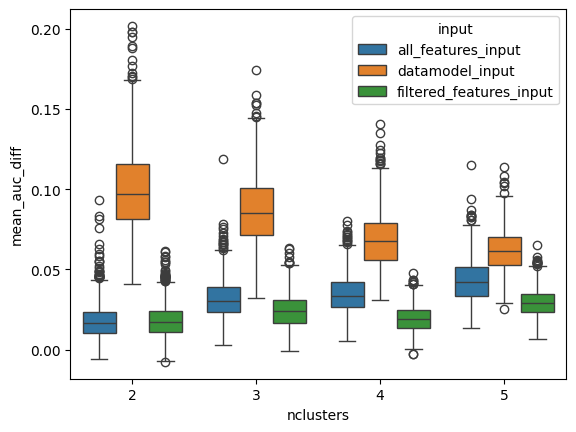

In [90]:
df_flat = df_wide.reset_index()
sns.boxplot(data=df_flat, x='nclusters', y='mean_auc_diff', hue='input')

In [74]:
# plot diffs in AUC

out = []

for i in  np.unique(d['input']):
    temp = d[d['input']==i]

    df_pivot = temp.pivot(index='model_seed', 
                        columns='prob_type', 
                        values='mean_auc')

    # compute on – out
    df_pivot['on_minus_out'] = (
        df_pivot['evaluation_on_split']
        - df_pivot['evaluation_outside_split']
    )

    result = df_pivot[['on_minus_out']].reset_index()
    result['type'] = i
    out.append(result)

out = pd.concat(out)

NameError: name 'd' is not defined

all_features_input vs. filtered_features_input: Mann-Whitney-Wilcoxon test two-sided, P_val:3.223e-62 U_stat=6.281e+06
filtered_features_input vs. datamodel_input: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=1.554e+07
all_features_input vs. datamodel_input: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=1.479e+07


<Axes: xlabel='input', ylabel='mean_auc'>

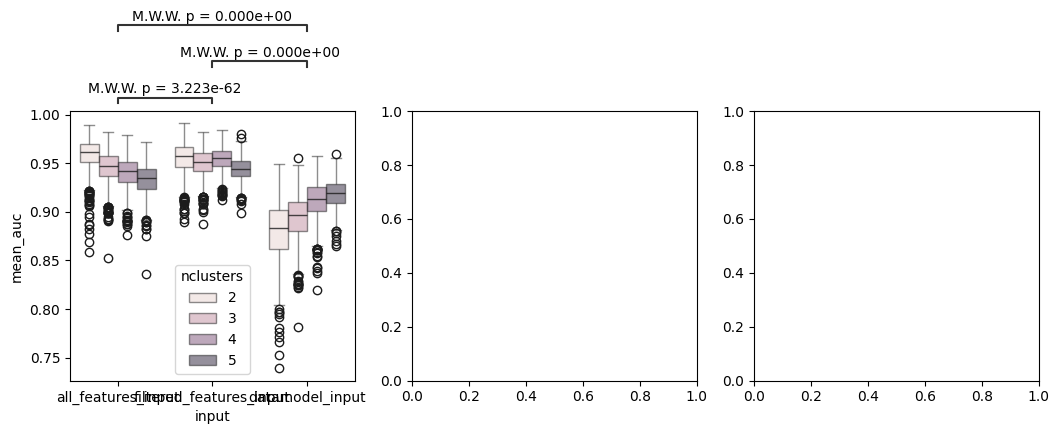

<Axes: xlabel='input', ylabel='mean_auc'>

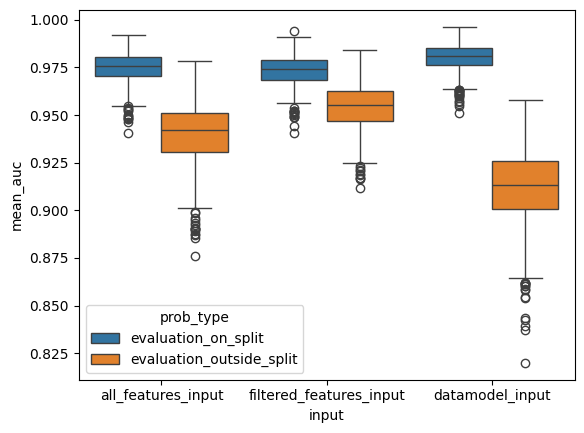

In [62]:
sns.boxplot(data=all_data[all_data['nclusters']==4], x='input', y='mean_auc', hue='prob_type')

<Axes: xlabel='nclusters', ylabel='mean_auc'>

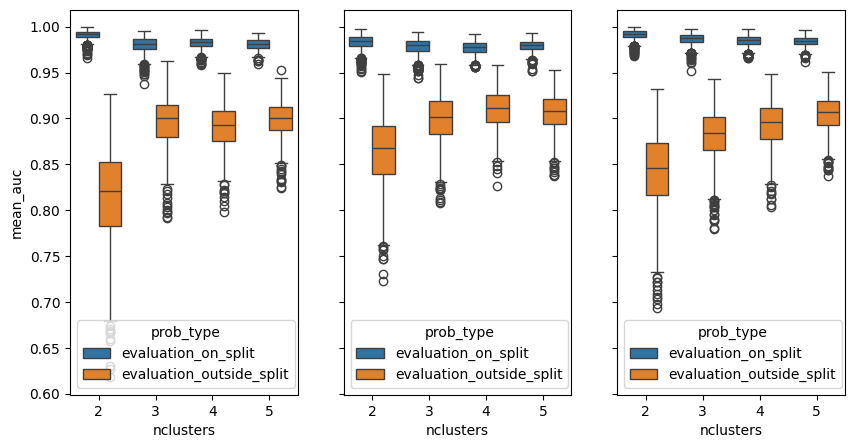

In [46]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5), sharey=True)
sns.boxplot(data=all_data[all_data['input']=='all_features_input'], x='nclusters', y='mean_auc', hue='prob_type', ax=axes[0])
sns.boxplot(data=all_data[all_data['input']=='filtered_features_input'], x='nclusters', y='mean_auc', hue='prob_type', ax=axes[1])
sns.boxplot(data=all_data[all_data['input']=='datamodel_input'], x='nclusters', y='mean_auc', hue='prob_type', ax=axes[2])

<Axes: xlabel='nclusters', ylabel='mean_auc'>

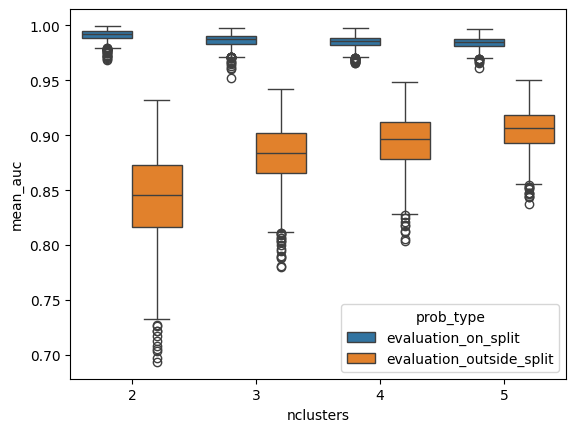

In [ ]:
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn import set_config
from tqdm import tqdm
from subgroups.utils.scoring import compute_margins

#set_config(display='text')

n_iter = 10
all_aucs = []
all_margins = []
for i in tqdm(range(n_iter)):
    children = fork_rng(np.random.default_rng(i), 3)

    X_tr, X_te, y_tr, y_te = train_test_split(
        experiment.dataset.features[:,pc_indices], np.invert(experiment.dataset.coarse_labels),
        train_size=0.012507530044163674,
        #stratify=np.invert(experiment.dataset.coarse_labels),        # <-- ensures y’s class distribution is preserved
        shuffle=True,
        random_state=np.random.RandomState(children[0].bit_generator)
    )

    rus = RandomUnderSampler(random_state=np.random.RandomState(children[1].bit_generator))
    X_tr_bal, y_tr_bal = rus.fit_resample(X_tr, y_tr)

    model = XgbFactory(max_depth=7).build_model(rng=np.random.default_rng(children[2]))
    model.fit(X_tr_bal, y_tr_bal)
    pred = model.predict_proba(X_te)
    auc = roc_auc_score(y_te, pred[:,1])
    margins = compute_margins(pred[:,1], y_te)
    all_aucs.append(auc)
    all_margins.append(np.mean(margins))

res_baseline = pd.DataFrame(np.hstack(all_aucs), columns = ['mean_auc'])
res_baseline['type'] = 'baseline'
res_baseline['seed'] = np.arange(len(res_baseline))
res_baseline['prob_type'] = 'not applicable'
res_baseline['mean_margins'] = np.hstack(all_margins)

In [40]:
all_data['input'].unique()

array(['all_features_input', 'filtered_features_input', 'datamodel_input'],
      dtype=object)

In [22]:
files[0].split('_')[-5]


'2'

In [ ]:
data = pd.read_csv('')

### Below is scrap

In [3]:
# Make tests
# Figure out selection of train size
# Make pipeline code to run experiments for the different baseline checks & run with different baselines & make those plots
from subgroups.counterfactuals.counterfactuals import CounterfactualEvaluation, CounterfactualExperimentResults
from subgroups.counterfactuals.datahandling import PartitionStorageBase, CounterfactualInputs, CounterfactualInputsGTExSubset
from subgroups.experiments.run_counterfactuals import get_cfg_inputs, run_counterfactuals
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [4]:
# load data
path = '/Users/djuna/Documents/temp/results/gtex_subset_experiment_june_30/datamodel_outputs/'
weights, batch_number = load_weights_data(path)
x = load_eval_data(path, 'pearson_correlations')[0]
weights = weights[x!=0]
index_grp_1 = (experiment.dataset.coarse_labels)
index_grp_2 = np.invert(index_grp_1)

In [1]:
from subgroups.experiments.pipeline_cfl import pipeline_counterfactuals
from subgroups.counterfactuals.registry import gtex_counterfactual_inputs, gtex_counterfactual_estimator

In [2]:
inputs = gtex_counterfactual_inputs()
estimator = gtex_counterfactual_estimator()

In [6]:
from subgroups.experiments.run_counterfactuals import get_cfg_inputs, run_counterfactuals
import chz
import numpy as np
from subgroups.utils.random import fork_rng
from subgroups.counterfactuals.base import CounterfactualInputsInterface, CounterfactualEvaluationInterface

@chz.chz
class CounterfactualExperimentArgs:

    counterfactual_inputs: CounterfactualInputsInterface = chz.field(default=None, doc='The dataset used for the experiment.')
    counterfactual_estimator: CounterfactualEvaluationInterface = chz.field(default=None, doc='Factory for generating masks. This will be used for training the classifier.')
    experiment_seed: int = chz.field(default=None, doc='Factory for creating models. This will be used for training the classifier.')
    n_iter: int = chz.field(default=None, doc='Number of models to build from ModelFactory. Each model will be trained on a different mask from MaskFactory.')
    n_clusters: int = chz.field(default=None, doc='Flag indicating whether to store results in memory.')
    in_memory: bool = chz.field(default=True, doc='Flag indicating whether to store results in memory.')
    path: str = chz.field(default=None, doc='Path for storing results if not in memory.')


def run_pipeline_counterfactuals(args: CounterfactualExperimentArgs):
    
    children = fork_rng(np.random.default_rng(args.experiment_seed), 2)
    cfg = get_cfg_inputs(args.counterfactual_inputs.pca_input, args.counterfactual_inputs.datamodel_input, args.counterfactual_inputs.pca_filtered_input)
    results = run_counterfactuals(cfg, args.counterfactual_estimator, n_iter=args.n_iter, n_clusters=args.n_clusters, model_rng=children[0], shuffle_rng=children[1])

    if args.in_memory:
        return results
    else:
        results.to_csv(args.path, index=False)
        return args.path
    
def pipeline_counterfactuals(counterfactual_inputs: CounterfactualInputsInterface, counterfactual_estimator: CounterfactualEvaluationInterface, experiment_seed: int, n_iter: int, n_clusters: int, in_memory: bool, out_path: str=None):
    
    args = CounterfactualExperimentArgs(counterfactual_inputs=counterfactual_inputs, 
                                 counterfactual_estimator=counterfactual_estimator, 
                                 experiment_seed=experiment_seed, n_iter=n_iter, 
                                 n_clusters=n_clusters, 
                                 in_memory=in_memory, 
                                 path=out_path)
    
    results = run_pipeline_counterfactuals(args)

    if in_memory:
        return results
    else:
        print(f"Counterfactual results saved to {results}")
    
    

In [15]:
def gtex_counterfactual_estimator():
    experiment = gtex_subset_experiment_home()
    return CounterfactualEvaluation(features=experiment.dataset.features[:,SelectPCsBasic().feature_indices(n_pcs=20)],
                                                        coarse_labels=experiment.dataset.coarse_labels,
                                                        train_size=int((0.012507530044163674*experiment.dataset.num_samples)/2), # corresponds to approx original model alpha of 0.012507530044163674
                                                        test_size=int((0.1*experiment.dataset.num_samples)/2),
                                                        classifier=XgbFactory(max_depth=7),
                                                        group_1=True)

In [16]:
import pandas as pd
import seaborn as sns
import numpy as np

In [28]:
d = pd.read_csv('/Users/djuna/Documents/temp/results/gtex_subset_experiment_june_30/clustering_outputs/batch_0_nclusters_2_group_1_counterfactual_results.csv')
d.head()

,model_seed,prob_type,mean_auc,mean_margins,input
0,0,evaluation_on_split,0.990764,2.475542,all_features_input
1,0,evaluation_outside_split,0.784931,0.552379,all_features_input
2,1,evaluation_on_split,0.984688,2.319127,all_features_input
3,1,evaluation_outside_split,0.844062,0.761368,all_features_input
4,2,evaluation_on_split,0.992292,2.432444,all_features_input


/Users/djuna/Documents/temp/subgroups/utils/plotting.py:124: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/Users/djuna/Documents/temp/subgroups/utils/plotting.py:128: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
/Users/djuna/Documents/temp/subgroups/utils/plotting.py:124: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/Users/djuna/Documents/temp/subgroups/utils/plotting.py:128: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False`

all_features_input vs. datamodel_input: Mann-Whitney-Wilcoxon test two-sided, P_val:3.579e-01 U_stat=4.881e+05
datamodel_input vs. filtered_features_input: Mann-Whitney-Wilcoxon test two-sided, P_val:2.272e-146 U_stat=8.327e+05
all_features_input vs. filtered_features_input: Mann-Whitney-Wilcoxon test two-sided, P_val:2.175e-151 U_stat=8.384e+05
all_features_input vs. datamodel_input: Mann-Whitney-Wilcoxon test two-sided, P_val:7.011e-06 U_stat=1.836e+06
datamodel_input vs. filtered_features_input: Mann-Whitney-Wilcoxon test two-sided, P_val:2.118e-07 U_stat=2.189e+06
all_features_input vs. filtered_features_input: Mann-Whitney-Wilcoxon test two-sided, P_val:6.108e-02 U_stat=2.068e+06


/Users/djuna/Documents/temp/subgroups/utils/plotting.py:124: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/Users/djuna/Documents/temp/subgroups/utils/plotting.py:124: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(
/Users/djuna/Documents/temp/subgroups/utils/plotting.py:128: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
/Users/djuna/Documents/temp/subgroups/utils/plotting.py:128: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.stripplot(
/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_1789/58143218

all_features_input vs. datamodel_input: Mann-Whitney-Wilcoxon test two-sided, P_val:4.898e-33 U_stat=6.546e+05
datamodel_input vs. filtered_features_input: Mann-Whitney-Wilcoxon test two-sided, P_val:1.699e-54 U_stat=7.007e+05
all_features_input vs. filtered_features_input: Mann-Whitney-Wilcoxon test two-sided, P_val:1.718e-130 U_stat=8.139e+05


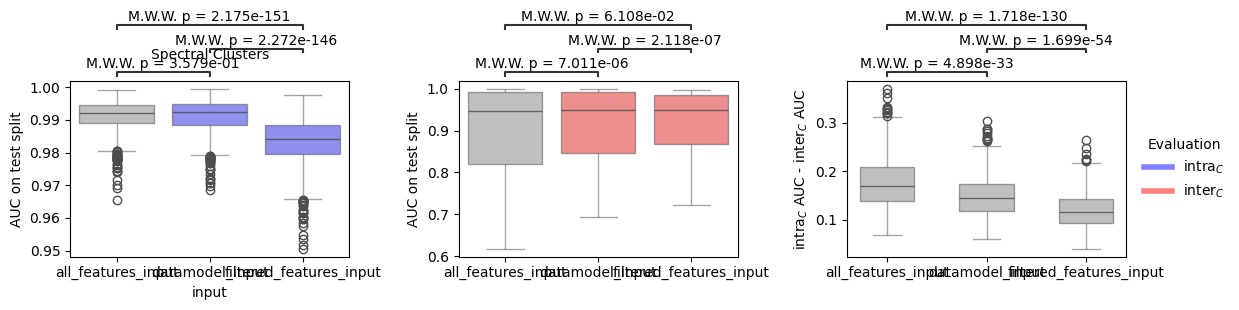

In [29]:
from subgroups.utils.plotting import plot_cat_continuous
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(12.5, 3.5), sharey=False, sharex=False)

plot_cat_continuous(
        data=d[d['prob_type']!='evaluation_outside_split'],
        cat_col='input',
        cont_col='mean_auc',
        test='Mann-Whitney',
        text_format='full',
        palette=['grey', 'blue', 'blue'],
        ax=axes[0],
        #y_lower=0.8,
        #y_upper=1.2,
        loc='outside',
        boxplot_kwargs={
            'boxprops':     {'alpha': 0.5},
            'whiskerprops': {'alpha': 0.5},
            'capprops':     {'alpha': 0.5},
            'medianprops':  {'alpha': 0.8},
            'width': 0.8
        },
        #order = ['baseline', 'PCA', 'datamodels'],
        stripplot_kwargs={'alpha': 0.6, 'size': 0}
    )

plot_cat_continuous(
        data=d[d['prob_type']!='evaluations_on_split'],
        cat_col='input',
        cont_col='mean_auc',
        test='Mann-Whitney',
        text_format='full',
        palette=['grey', 'red', 'red'],
        ax=axes[1],
       #y_lower=0.5,
        #y_upper=1.2,
        boxplot_kwargs={
            'boxprops':     {'alpha': 0.5},
            'whiskerprops': {'alpha': 0.5},
            'capprops':     {'alpha': 0.5},
            'medianprops':  {'alpha': 0.8},
            'width': 0.8
        },
        #order = ['baseline', 'PCA', 'datamodels'],
        stripplot_kwargs={'alpha': 0.6, 'size': 0}
    )

# plot diffs in AUC

out = []

for i in  np.unique(d['input']):
    temp = d[d['input']==i]

    df_pivot = temp.pivot(index='model_seed', 
                        columns='prob_type', 
                        values='mean_auc')

    # compute on – out
    df_pivot['on_minus_out'] = (
        df_pivot['evaluation_on_split']
        - df_pivot['evaluation_outside_split']
    )

    result = df_pivot[['on_minus_out']].reset_index()
    result['type'] = i
    out.append(result)

out = pd.concat(out)

plot_cat_continuous(
        data=out,
        cat_col='type',
        cont_col='on_minus_out',
        test='Mann-Whitney',
        text_format='full',
        palette=['grey', 'grey'],
        ax=axes[2],
        boxplot_kwargs={
            'boxprops':     {'alpha': 0.5},
            'whiskerprops': {'alpha': 0.5},
            'capprops':     {'alpha': 0.5},
            'medianprops':  {'alpha': 0.8},
            'width': 0.55
        },
        #y_lower=0,
        #y_upper=0.1,
        #order = ['PCA', 'datamodels'],
        stripplot_kwargs={'alpha': 0.6, 'size': 0}
    )

for ax in axes[1:]:
    ax.set_xlabel('')
    ax.set_ylabel('')

axes[1].set_ylabel('AUC')

line1, = axes[-1].plot(0, 0, lw=4, color='blue', alpha=0.5)
line2, = axes[-1].plot(0, 0, lw=4, color='red', alpha=0.5)

# now add a manual legend to just that last subplot:
axes[-1].legend(
    [line1, line2],               # the “handles”
    [r'intra$_C$', r'inter$_C$'],       # the “labels”
    loc='center left',           # anchor the legend’s center‐left
    bbox_to_anchor=(1.02, 0.5),         # position
    title='Evaluation',           # optional title
    frameon=False,                 # draw a box around it
    fontsize='medium'              # adjust text size
)

axes[0].set_ylabel('AUC on test split')
axes[1].set_ylabel('AUC on test split')
axes[2].set_ylabel(r'intra$_C$ AUC - inter$_C$ AUC')

axes[0].legend(
       # the “labels”
    title='Spectral Clusters',
    ncol=3,
    loc='lower center', 
    markerscale=2,
    frameon=False,
    bbox_to_anchor=(0.5, 1)          # adjust text size
)

axes[1].axhline(y=0.5, color='gray', linestyle='--', linewidth=1)
axes[2].axhline(y=0.5, color='gray', linestyle='--', linewidth=1)

plt.tight_layout()
#plt.savefig('/Users/djuna/Documents/Maydell-MIT-PhD-Thesis/MIT-thesis-template/ch4_figs/rosmap_aucs.png', dpi=300)


In [2]:
import chz
from typing import Protocol, Any, Optional
from subgroups.datasets import DatasetInterface
from subgroups.datasamplers import MaskFactory, MaskFactoryInitializer
from subgroups.models import ModelFactory, ModelFactoryInitializer
from pathlib import Path
import os
from subgroups.datasamplers.random_generators import RandomGeneratorSNRInterface, RandomGeneratorTCInterface
from subgroups.experiments.stopping_condition import StoppingConditionInterface
from typing import Type
from subgroups.datamodels.base import DatamodelsPipelineInterface
from subgroups.datamodels.indices import IndicesFunction
from subgroups.datasamplers.feature_selectors import SelectPCsInterface
from subgroups.counterfactuals.base import CounterfactualInputsInterface, CounterfactualEvaluationInterface

@chz.chz
class Experiment:
    """
    Class containing all the necessary information for running an experiment.

    Attributes
    ----------
    dataset : DatasetInterface
        The dataset used for the experiment.
    mask_factory : MaskFactory
        Factory for generating masks.
    model_factory : ModelFactory
        Factory for creating models.
    model_factory_initializer : ModelFactoryInitializer
        Initializer for the model factory.
    mask_factory_initializer : MaskFactoryInitializer
        Initializer for the mask factory.
    snr_n_models : int
        Number of models to build from ModelFactory. Each model will be trained on a different mask from MaskFactory.
    snr_n_passes : int
        Number of model initializations for SNR.
    snr_random_generator : Type[RandomGeneratorSNRInterface]
        Random generator for SNR experiments.
    tc_random_generator : Type[RandomGeneratorTCInterface]
        Random generator for TC experiments.
    in_memory : bool
        Flag indicating if the experiment should be conducted in memory.
    path : Path
        Path to store experiment results if not in memory.
    experiment_name : str
        Name of the experiment.
    stopping_condition : StoppingConditionInterface
        Stopping condition for the SNR experiment.
    """
    dataset: DatasetInterface=chz.field(default=None, doc='The dataset used for the experiment.')
    mask_factory: MaskFactory=chz.field(default=None, doc='Factory for generating masks. This will be used for training the classifier.')
    model_factory: ModelFactory=chz.field(default=None, doc='Factory for creating models. This will be used for training the classifier.')
    model_factory_initializer: ModelFactoryInitializer=chz.field(default=None, doc='Initializer for the model factory. This will be used to sample instances of ModelFactory with different hyperparameters for the SNR experiment.')
    mask_factory_initializer: MaskFactoryInitializer=chz.field(default=None, doc='Initializer for the mask factory. This will be used to sample instances of MaskFactory with different hyperparameters for the SNR experiment.')
    snr_n_models: int=chz.field(default=20, doc='Number of models to build from ModelFactory. Each model will be trained on a different mask from MaskFactory.')
    snr_n_passes: int=chz.field(default=15, doc='Number of passes over the same mask matrix for the SNR experiment (the number of times ModelFactory.build_model(seed=i) will be called with different seeds).')
    in_memory: bool=chz.field(default=True, doc='Flag indicating if the results to any experiment pipelines run on this experiment object will be stored in memory.')
    path: str=chz.field(default=None, doc='Path to store experiment results if not in memory.')
    experiment_name: str=chz.field(default=None, doc='Name of the experiment if not in memory.')
    snr_random_generator: Type[RandomGeneratorSNRInterface]=chz.field(default=None, doc='Random generator for SNR experiments. Will return independent random seeds for each component of the SNR experiment, based on a batch starter seed.')
    tc_random_generator: Type[RandomGeneratorTCInterface]=chz.field(default=None, doc='Random generator for TC experiments. Will return independent random seeds for each component of the TC experiment, based on a batch starter seed.')
    stopping_condition: StoppingConditionInterface=chz.field(default=None, doc='Stopping condition for the SNR experiment.')
    datamodels_pipeline: DatamodelsPipelineInterface=chz.field(default=None, doc='Datamodels pipeline for the experiment.')
    dm_n_train: int=chz.field(default=None, doc='Number of training samples for the datamodels pipeline.')
    dm_n_test: Optional[int]=chz.field(default=None, doc='Number of test samples for the datamodels pipeline.')
    indices_to_fit: IndicesFunction=chz.field(default=None, doc='Indices to fit for the experiment.')
    notes: str=chz.field(default=None, doc='Notes for the experiment.')
    npcs_min: int=chz.field(default=5, doc='Minimum number of PCs to use for the SNR experiment.')
    npcs_max: int=chz.field(default=50, doc='Maximum number of PCs to use for the SNR experiment.')
    feature_selector: SelectPCsInterface=chz.field(default=None, doc='Feature selector for the experiment.')
    npcs: int=chz.field(default=None, doc='Number of PCs to use for the experiment.')
    counterfactual_inputs: CounterfactualInputsInterface=chz.field(default=None, doc='Counterfactual inputs for the experiment.')
    counterfactual_estimator: CounterfactualEvaluationInterface=chz.field(default=None, doc='Counterfactual estimator for the experiment.')
    counterfactual_test_fraction: float=chz.field(default=0.1, doc='Fraction of the dataset to use for the counterfactual test set.')

    @chz.init_property
    def _check_path(self):
        """
        Check if the path to the experiment results is provided if in_memory is False.
        """
        if not self.in_memory and self.path is None:
            raise ValueError("path to output must be provided if in_memory is False")
        if self.path is not None and self.experiment_name is None:
            raise ValueError("experiment_name must be provided if path is provided")

    @chz.init_property
    def path_to_results(self):
        """
        Path to the results of the experiment.
        """
        if self.in_memory:
            return None
        else:
            return os.path.join(self.path, self.experiment_name)

    @chz.init_property
    def path_to_classifier_outputs(self):
        """
        Path to the classifier outputs of the experiment.
        """
        if self.in_memory:
            return None
        else:
            return os.path.join(self.path_to_results, 'classifier_outputs')

    @chz.init_property
    def path_to_datamodel_outputs(self):
        """
        Path to the datamodel outputs of the experiment.
        """
        if self.in_memory:
            return None
        else:
            return os.path.join(self.path_to_results, 'datamodel_outputs')
    
    @chz.init_property
    def path_to_clustering_outputs(self):
        """
        Path to the clustering outputs of the experiment.
        """
        if self.in_memory:
            return None
        else:
            return os.path.join(self.path_to_results, 'clustering_outputs')
    
    @chz.init_property
    def path_to_benchmarks(self):
        """
        Path to the benchmarks of the experiment.
        """
        if self.in_memory:
            return None
        else:
            return os.path.join(self.path_to_results, 'benchmarks')

    @chz.init_property
    def path_to_plots(self):
        """
        Path to the plots of the experiment.
        """
        if self.in_memory:
            return None
        else:
            return os.path.join(self.path_to_results, 'plots')

    @chz.init_property
    def path_to_snr_outputs(self):
        """
        Path to the SNR outputs of the experiment.
        """
        if self.in_memory:
            return None
        else:
            return os.path.join(self.path_to_results, 'snr_outputs')

    @chz.init_property
    def _prepare_experiment(self):
        """
        If not in memory, prepare an experiment with the given configuration.
        """
        if not self.in_memory:
            if not os.path.exists(self.path_to_results):
                os.makedirs(self.path_to_results)
                os.makedirs(self.path_to_classifier_outputs)
                os.makedirs(self.path_to_datamodel_outputs)
                os.makedirs(self.path_to_clustering_outputs)
                os.makedirs(self.path_to_benchmarks)
                os.makedirs(self.path_to_plots)
                os.makedirs(self.path_to_snr_outputs)



In [1]:
from subgroups.datasets.registry import gtex, gtex_subset, ace_csf_proteomics, ace_plasma_proteomics, rosmap_singlecell, ace_plasma_csf_proteomics
from subgroups.datasets.test_data import RandomDataset
from subgroups.datasamplers.mask_generators import fixed_alpha_mask_factory
from subgroups.models.classifier import XgbFactory
from subgroups.models.classifier import XgbFactoryInitializer
from subgroups.datasamplers.mask_generators import fixed_alpha_mask_factory_initializer
from subgroups.datastorage.experiment import Experiment
from subgroups.datasamplers.random_generators import RandomGeneratorSNR, RandomGeneratorTC
from subgroups.experiments.stopping_condition import SNRPrecisionStopping
from subgroups.utils.pick_best_architecture import return_best_model_architecture
from subgroups.datamodels.datamodels_pipeline import DatamodelsPipelineBasic
from subgroups.datamodels.regressor import LassoFactory, LinearRegressionFactory
from subgroups.datamodels.indices import SequentialIndices
import os
from subgroups.datasets.ace import AceDataset
from subgroups.datasets.gtex import GTEXDataset
import chz
from subgroups.datastorage.combined_mask_margin import CombinedMaskMarginStorage
from subgroups.datasamplers.feature_selectors import SelectPCsBasic, SelectPCsSingleCell










In [50]:

Experiment()

Experiment(
    # Fields where pre-init value matches default:
    counterfactual_estimator=None,
    counterfactual_inputs=None,
    counterfactual_test_fraction=0.1,
    datamodels_pipeline=None,
    dataset=None,
    dm_n_test=None,
    dm_n_train=None,
    experiment_name=None,
    feature_selector=None,
    in_memory=True,
    indices_to_fit=None,
    mask_factory=None,
    mask_factory_initializer=None,
    model_factory=None,
    model_factory_initializer=None,
    notes=None,
    npcs=None,
    npcs_max=50,
    npcs_min=5,
    path=None,
    snr_n_models=20,
    snr_n_passes=15,
    snr_random_generator=None,
    stopping_condition=None,
    tc_random_generator=None,
)

In [2]:
from subgroups.counterfactuals.counterfactuals import CounterfactualEvaluation
from subgroups.counterfactuals.datahandling import CounterfactualInputsBasic
from subgroups.datasets.gtex import GTEXDataset

def gtex_subset_experiment_home() -> Experiment:
    path = "/Users/djuna/Documents/temp/results"
    name = "gtex_subset_experiment_june_30"

    mask_factory = fixed_alpha_mask_factory(alpha=0.012507530044163674)
    model_factory = XgbFactory(max_depth=7)

    return Experiment(
        dataset=GTEXDataset(
        path_to_data="/Users/djuna/Documents/subgroups_data/gtex_subset/subset_esophagus_bloodvessel.gct",
        path_to_meta_data='/Users/djuna/Documents/subgroups_data/gtex/GTEx_Analysis_v10_Annotations_SampleAttributesDS.txt',
        path_to_sample_metadata='/Users/djuna/Documents/subgroups_data/gtex/GTEx_Analysis_v10_Annotations_SubjectPhenotypesDS.txt',
        predicted_class='Esophagus',
        n_components=500
    ),
        mask_factory=mask_factory,
        model_factory=model_factory,
        model_factory_initializer=XgbFactoryInitializer(), 
        mask_factory_initializer=fixed_alpha_mask_factory_initializer(upper_bound=0.2),
        in_memory=False,
        snr_n_models=1000,
        snr_n_passes=50,
        snr_random_generator=RandomGeneratorSNR, 
        tc_random_generator=RandomGeneratorTC,
        path=path,
        experiment_name=name,
        stopping_condition=SNRPrecisionStopping(tolerance=0.1),
        indices_to_fit=SequentialIndices(batch_size=50),
        dm_n_train=9000,
        dm_n_test=1000,
        npcs_min=5,
        npcs_max=500,
        npcs=20,
        feature_selector=SelectPCsBasic(),
        counterfactual_test_fraction=0.1,
        counterfactual_inputs=CounterfactualInputsBasic,
        counterfactual_estimator=CounterfactualEvaluation,
        datamodels_pipeline=DatamodelsPipelineBasic(datamodel_factory=LinearRegressionFactory(),
                                                    combined_mask_margin_storage=CombinedMaskMarginStorage(path_to_inputs=os.path.join(path, name, "classifier_outputs")),
                                                    path_to_outputs=os.path.join(path, name, "datamodel_outputs")),
    )


In [3]:
x = gtex_subset_experiment_home()

In [8]:
import numpy as np

np.mean(x.dataset.untransformed_features[x.dataset.coarse_labels],axis=0)


array([8.34156210e-03, 4.12647803e+00, 1.07785932e-02, ...,
       2.27167808e+04, 5.51655039e-01, 2.29338107e+00], shape=(59033,))

In [4]:
o = CounterfactualInputsBasic(path_to_weights='/Users/djuna/Documents/temp/results/gtex_subset_experiment_june_30/datamodel_outputs', dataset=x.dataset, group_1=True)

In [8]:
f = o.to_counterfactual_inputs

In [10]:
for name, mat in f:
    print(mat.shape)

(1578, 59033)
(1578, 1578)
(1578, 1578)


In [22]:
from subgroups.experiments.run_counterfactuals import  run_counterfactuals
import chz
import numpy as np
from subgroups.utils.random import fork_rng
from subgroups.counterfactuals.base import CounterfactualInputsInterface, CounterfactualEvaluationInterface
from subgroups.datastorage.experiment import Experiment
import os

@chz.chz
class CounterfactualExperimentArgs:

    counterfactual_inputs: CounterfactualInputsInterface = chz.field(default=None, doc='The dataset used for the experiment.')
    counterfactual_estimator: CounterfactualEvaluationInterface = chz.field(default=None, doc='Factory for generating masks. This will be used for training the classifier.')
    experiment_seed: int = chz.field(default=None, doc='Factory for creating models. This will be used for training the classifier.')
    n_iter: int = chz.field(default=None, doc='Number of models to build from ModelFactory. Each model will be trained on a different mask from MaskFactory.')
    n_clusters: int = chz.field(default=None, doc='Flag indicating whether to store results in memory.')
    in_memory: bool = chz.field(default=True, doc='Flag indicating whether to store results in memory.')
    path: str = chz.field(default=None, doc='Path for storing results if not in memory.')


def run_pipeline_counterfactuals(args: CounterfactualExperimentArgs):
    
    children = fork_rng(np.random.default_rng(args.experiment_seed), 2)
    results = run_counterfactuals(args.counterfactual_inputs.to_counterfactual_inputs, args.counterfactual_estimator, n_iter=args.n_iter, n_clusters=args.n_clusters, model_rng=children[0], shuffle_rng=children[1])

    if args.in_memory:
        return results
    else:
        results.to_csv(args.path, index=False)
        return args.path
    
def pipeline_counterfactuals(experiment: Experiment, experiment_seed: int, n_iter: int, n_clusters: int, in_memory: bool, group_1: bool=True):

    if not in_memory:
        out_path = os.path.join(experiment.path, experiment.experiment_name, "clustering_outputs", "counterfactual_results.csv")
    else:
        out_path = None
    
    counterfactual_inputs = experiment.counterfactual_inputs(path_to_features=experiment.dataset.path_to_data, 
                                                       path_to_weights=os.path.join(experiment.path, experiment.experiment_name, "datamodel_outputs"), 
                                                       dataset=experiment.dataset,
                                                       group_1=group_1)


    counterfactual_estimator = experiment.counterfactual_estimator(features=experiment.dataset.features[:,experiment.feature_selector.feature_indices(n_pcs=experiment.npcs)],
                                                        coarse_labels=experiment.dataset.coarse_labels,
                                                        train_size=int((experiment.mask_factory.alpha*experiment.dataset.num_samples)/5), # corresponds to approx original model alpha of 0.012507530044163674
                                                        test_size=int((experiment.counterfactual_test_fraction*experiment.dataset.num_samples)/5),
                                                        classifier=experiment.model_factory,
                                                        group_1=group_1)

    args = CounterfactualExperimentArgs(counterfactual_inputs=counterfactual_inputs, 
                                 counterfactual_estimator=counterfactual_estimator, 
                                 experiment_seed=experiment_seed, n_iter=n_iter, 
                                 n_clusters=n_clusters, 
                                 in_memory=in_memory, 
                                 path=out_path)
    
    results = run_pipeline_counterfactuals(args)

    if in_memory:
        return results
    else:
        print(f"Counterfactual results saved to {results}")
    
    


In [23]:
res = pipeline_counterfactuals(estimator, experiment_seed=0, n_iter=10, n_clusters=3, in_memory=True, group_1=True)

# is it because I don't filter the weights as before?
# is there something wrong with my correlation matrix and are the inputs for spectral clustering correct?

<Axes: xlabel='prob_type', ylabel='mean_auc'>

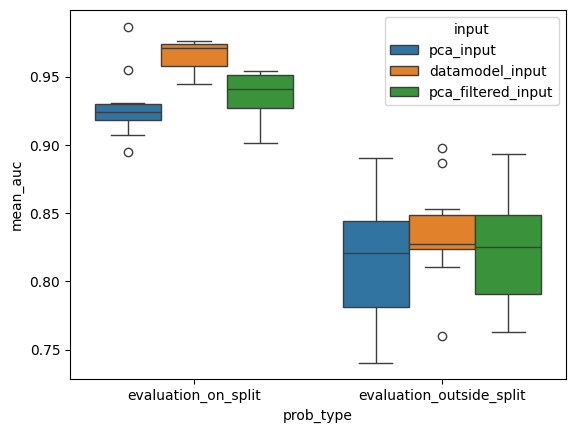

In [24]:
import seaborn as sns

sns.boxplot(data=res, x='prob_type', y='mean_auc', hue='input')

<Axes: xlabel='prob_type', ylabel='mean_margins'>

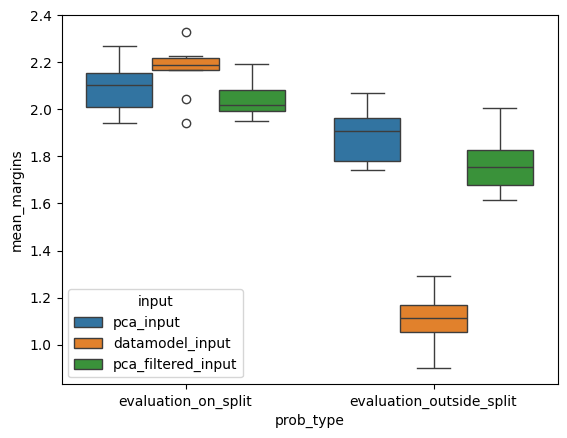

In [13]:
import seaborn as sns

sns.boxplot(data=res, x='prob_type', y='mean_margins', hue='input')

<Axes: xlabel='prob_type', ylabel='mean_auc'>

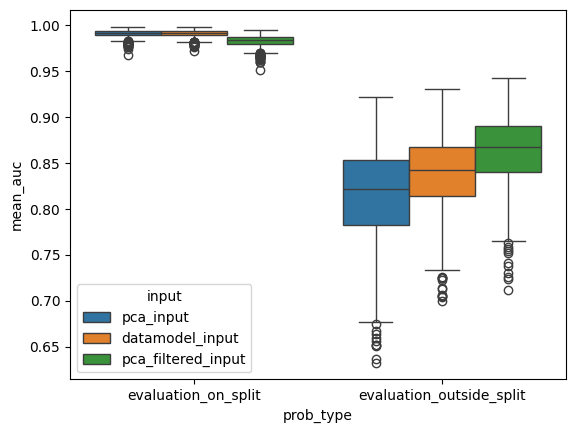

In [10]:
import seaborn as sns

sns.boxplot(data=res, x='prob_type', y='mean_auc', hue='input')

<Axes: xlabel='prob_type', ylabel='mean_margins'>

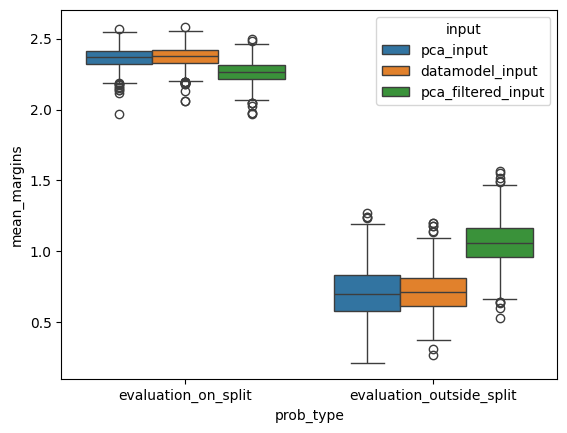

In [17]:
import seaborn as sns

sns.boxplot(data=res, x='prob_type', y='mean_margins', hue='input')

<Axes: xlabel='prob_type', ylabel='mean_auc'>

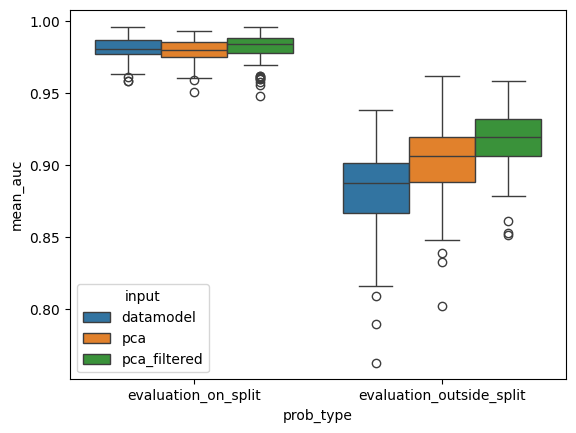

In [14]:
import seaborn as sns

sns.boxplot(data=res, x='prob_type', y='mean_auc', hue='input')



In [5]:
# process inputs
tpm_data = pd.read_csv("/Users/djuna/Documents/subgroups_data/gtex_subset/subset_esophagus_bloodvessel.gct", sep='\t', skiprows=2)
tmp_data = tpm_data.iloc[:, 2:].T

group_2_index = experiment.dataset.descriptive_data['SAMPID'][np.invert(experiment.dataset.coarse_labels)]
data_temp = tmp_data.loc[group_2_index]

tmp_data_low_removed = tmp_data.loc[:,(tmp_data==0).sum(axis=0)<(0.3*tmp_data.shape[0])]
avs = tmp_data_low_removed.groupby(experiment.dataset.coarse_labels).mean()
avs_array = np.array(avs) + np.finfo(float).eps
lfcs = np.array(np.abs(np.log2(avs_array[0]/avs_array[1])))
curr = tmp_data.iloc[:,np.argsort(lfcs)[-np.sum(index_grp_2):]]
curr_data = curr.loc[index_grp_2]

pca_input = data_temp.values.astype(float)
pca_filtered = curr_data.values.astype(float)
datamodel_input = weights[index_grp_2][:,index_grp_2]

In [19]:
from abc import ABC, abstractmethod
from dataclasses import dataclass
from subgroups.utils.loading import load_weights_data, load_eval_data
import chz
import numpy as np
import pandas as pd

@chz.chz
@abstractmethod
class CounterfactualInputsInterface(ABC):
    @abstractmethod
    @chz.init_property
    def pca_input(self)->np.ndarray:
        ...
    
    @abstractmethod
    @chz.init_property
    def datamodel_input(self)->np.ndarray:
        ...

    @abstractmethod
    @chz.init_property
    def pca_filtered_input(self)->np.ndarray:
        ...
    

@chz.chz
class CounterfactualInputsGTExSubset(CounterfactualInputsInterface):
    
    path_to_features: str
    path_to_weights: str
    sample_index: np.ndarray

    @chz.init_property
    def _features(self)->np.ndarray:
        tpm_data = pd.read_csv(self.path_to_features, sep='\t', skiprows=2)
        return tpm_data.iloc[:, 2:].T


    @chz.init_property
    def _features_filtered(self)->np.ndarray:

        tmp_data_low_removed = self._features.loc[:,(self._features==0).sum(axis=0)<(0.3*self._features.shape[0])]
        avs = tmp_data_low_removed.groupby(experiment.dataset.coarse_labels).mean()
        avs_array = np.array(avs) + np.finfo(float).eps
        lfcs = np.array(np.abs(np.log2(avs_array[0]/avs_array[1])))
        features_subset = self._features.iloc[:,np.argsort(lfcs)[-np.sum(self.sample_index):]]
        
        return features_subset.loc[self.sample_index].values.astype(float)

    @chz.init_property
    def pca_input(self)->np.ndarray:
        
        return self._features.loc[self.sample_index].values.astype(float)
    
    @chz.init_property
    def datamodel_input(self)->np.ndarray:
        weights, _ = load_weights_data(self.path_to_weights)
        x = load_eval_data(self.path_to_weights, 'pearson_correlations')[0]
        weights = weights[x!=0]
        return weights[self.sample_index][:,self.sample_index]
    
    @chz.init_property
    def pca_filtered_input(self)->np.ndarray:

        return self._features_filtered

In [1]:
from subgroups.counterfactuals.registry import gtex_counterfactual_inputs, gtex_counterfactual_estimator

In [2]:
inputs = gtex_counterfactual_inputs()
estimator = gtex_counterfactual_estimator()



In [ ]:
# push
# write the tests
# design & launch all the counterfactual experiments
# can add baseline locally in plotting notebook

In [14]:
from subgroups.experiments.pipeline_cfl import pipeline_counterfactuals
from subgroups.counterfactuals.registry import gtex_counterfactual_inputs, gtex_counterfactual_estimator
from tqdm import tqdm
out = []
for i in tqdm(range(10)):
    x = pipeline_counterfactuals(inputs, estimator, experiment_seed=i, n_iter=100, n_clusters=2, in_memory=True)
    x['experiment_seed'] = i
    out.append(x)

100%|██████████| 10/10 [08:19<00:00, 49.99s/it]


In [18]:
import pandas as pd
d = pd.concat(out)

<Axes: xlabel='prob_type', ylabel='mean_margins'>

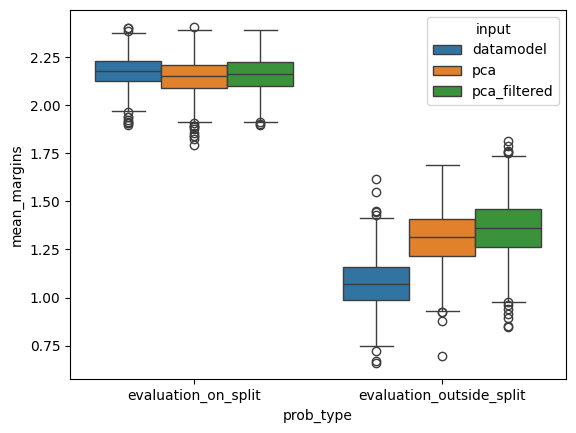

In [20]:
import seaborn as sns
sns.boxplot(data=d, x='prob_type', y='mean_margins', hue='input')

In [21]:
from subgroups.counterfactuals.counterfactuals import CounterfactualEvaluation
from subgroups.datasets.test_data import RandomDataset

In [1]:
from subgroups.counterfactuals.counterfactuals import CounterfactualEvaluation
from subgroups.datasets.test_data import RandomDataset
from subgroups.models.classifier import XgbFactory
dataset = RandomDataset()
eval = CounterfactualEvaluation(features=dataset.features, 
                         coarse_labels=dataset.coarse_labels, 
                         train_size=50, test_size=50, 
                         classifier=XgbFactory(max_depth=7))

import numpy as np
labs = np.zeros_like(dataset.coarse_labels)
labs[dataset.coarse_labels] = np.random.randint(0, 2, size=np.sum(dataset.coarse_labels))

outputs = eval._prepare_data(cluster_labels=labs,
                   sample_indices=None,
                   shuffle_rng=np.random.default_rng(0))

# data was partitioned into 3 nonverlapping groups


x_test = np.sum(outputs['A']['X_test'], axis=1)
x_train = np.sum(outputs['A']['X_train'], axis=1)

len(np.unique(np.concatenate([x_test, x_train])))==len(np.concatenate([x_test, x_train]))

True

In [32]:

    # Make predictions with class
    dataset = RandomDataset()
    eval = CounterfactualEvaluation(features=dataset.features, 
                            coarse_labels=dataset.coarse_labels, 
                            train_size=50, test_size=50, 
                            classifier=XgbFactory(max_depth=7))

    labs = np.zeros_like(dataset.coarse_labels)
    labs[dataset.coarse_labels] = np.random.randint(0, 2, size=np.sum(dataset.coarse_labels))

    res = eval.counterfactual_evaluation(partition=labs, sample_indices=None, model_rng=np.random.default_rng(0), shuffle_rng=np.random.default_rng(0), n_iter=1)


/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_63647/3172247058.py:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(temp[temp['prob_type']=='evaluation_on_split']['auc'])


0.556

In [78]:
from sklearn.metrics import roc_auc_score
from subgroups.utils.random import fork_rng


# Make predictions with class
dataset = RandomDataset()
eval = CounterfactualEvaluation(features=dataset.features, 
                        coarse_labels=dataset.coarse_labels, 
                        train_size=60, test_size=60, 
                        classifier=XgbFactory(max_depth=7))

labs = np.zeros_like(dataset.coarse_labels)
labs[dataset.coarse_labels] = np.random.randint(0, 2, size=np.sum(dataset.coarse_labels))

res = eval.counterfactual_evaluation(partition=labs, sample_indices=None, model_rng=np.random.default_rng(0), shuffle_rng=np.random.default_rng(0), n_iter=1)


def make_predictions(labs, model_rng, shuffle_rng):
    build_model_rngs_children = fork_rng(model_rng, 1)
    train_data_shuffle_rngs_children = fork_rng(shuffle_rng, 1)
    data = eval._prepare_data(cluster_labels=labs,
                    sample_indices=None,
                    shuffle_rng=train_data_shuffle_rngs_children[0])

    model = eval.classifier.build_model(rng=build_model_rngs_children[0])
    X_tr = np.concatenate([data['A']['X_train'], data['B']['X_train']])
    y_tr = np.concatenate([data['A']['y_train'], data['B']['y_train']])
    X_tr, y_tr = shuffle(X_tr, y_tr, random_state=np.random.RandomState(train_data_shuffle_rngs_children[0].bit_generator))
    model.fit(X_tr, y_tr)

    X_te = np.concatenate([data['A']['X_test'], data['B']['X_test']])
    y_te = np.concatenate([data['A']['y_test'], data['B']['y_test']])
    pred_1_1 = model.predict_proba(X_te)[:,1]

    X_te2 = np.concatenate([data['A']['X_test'], data['C']['X_test']])
    y_te2 = np.concatenate([data['A']['y_test'], data['C']['y_test']])
    pred_1_2 = model.predict_proba(X_te2)[:,1]
    return pred_1_1, pred_1_2, y_te, y_te2

pred_1_1, pred_1_2, y_te, y_te2 = make_predictions(labs, np.random.default_rng(0), np.random.default_rng(0))

rocauc_1_1 = roc_auc_score(y_te, pred_1_1)
rocauc_1_2 = roc_auc_score(y_te, pred_1_2   )
temp = res[res['split']=='split_a']
rocauc_1_1==float(temp[temp['prob_type']=='evaluation_on_split']['auc'])
temp = res[res['split']=='split_b']
rocauc_1_2==float(temp[temp['prob_type']=='evaluation_outside_split']['auc'])



/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_63647/1105732525.py:45: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rocauc_1_1==float(temp[temp['prob_type']=='evaluation_on_split']['auc'])
/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_63647/1105732525.py:47: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rocauc_1_2==float(temp[temp['prob_type']=='evaluation_outside_split']['auc'])


np.True_

In [76]:
res

,split,prob_type,auc,mean_margins,model_seed
0,split_a,evaluation_on_split,0.481667,0.002640,0
1,split_a,evaluation_outside_split,0.547778,0.185684,0
2,split_b,evaluation_on_split,0.603056,0.313054,0
3,split_b,evaluation_outside_split,0.541111,0.106572,0


In [77]:
rocauc_1_2


np.float64(0.5411111111111111)

In [58]:
float(temp[temp['prob_type']=='evaluation_outside_split']['auc'])

/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_63647/4062368675.py:1: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(temp[temp['prob_type']=='evaluation_outside_split']['auc'])


0.5772

In [60]:
temp

,split,prob_type,auc,mean_margins,model_seed
0,split_a,evaluation_on_split,0.4932,0.052951,0
1,split_a,evaluation_outside_split,0.5772,0.153811,0


In [59]:
float(rocauc_1_2)

0.5760000000000001

In [35]:
pred_1_1

array([0.82981294, 0.5352628 , 0.04114014, 0.8047895 , 0.49024394,
       0.4174801 , 0.4367022 , 0.21892576, 0.57669413, 0.52360606,
       0.6094647 , 0.9081378 , 0.8678083 , 0.7838471 , 0.85394347,
       0.8385073 , 0.9442823 , 0.30784824, 0.72936326, 0.83595854,
       0.7044675 , 0.65248847, 0.15202497, 0.8027257 , 0.7353077 ,
       0.48292065, 0.75229686, 0.24740316, 0.8615686 , 0.55488265,
       0.31318346, 0.593721  , 0.53890795, 0.6831265 , 0.3965413 ,
       0.5916689 , 0.30508846, 0.19320528, 0.9369046 , 0.6428645 ,
       0.1377916 , 0.7209828 , 0.10226766, 0.8891501 , 0.71450186,
       0.43616655, 0.4912961 , 0.367313  , 0.776417  , 0.72818875,
       0.7409357 , 0.14976484, 0.429553  , 0.8908851 , 0.24688555,
       0.872867  , 0.31278315, 0.33536634, 0.6994747 , 0.3341968 ,
       0.03137557, 0.10264644, 0.8558997 , 0.39455178, 0.6551614 ,
       0.10719474, 0.75488436, 0.8722015 , 0.20886675, 0.17805286,
       0.77740365, 0.05283905, 0.52529025, 0.49719104, 0.88851

In [ ]:
from sklearn.metrics import roc_auc_score

rocauc = roc_auc_score(labs, pred_1_1)
rocauc









In [22]:

    # Make predictions "manually"

    rng = np.random.default_rng(0)
    data = eval._prepare_data(cluster_labels=labs,
                    sample_indices=None,
                    shuffle_rng=rng)

    model = eval.classifier.build_model(rng=np.random.default_rng(0))
    X_tr = np.concatenate([data['A']['X_train'], data['B']['X_train']])
    y_tr = np.concatenate([data['A']['y_train'], data['B']['y_train']])
    X_tr, y_tr = shuffle(X_tr, y_tr, random_state=np.random.RandomState(rng.bit_generator))
    model.fit(X_tr, y_tr)

    X_te = np.concatenate([data['A']['X_test'], data['B']['X_test']])
    y_te = np.concatenate([data['A']['y_test'], data['B']['y_test']])
    pred_1_1 = model.predict_proba(X_te)[:,1]

    X_te2 = np.concatenate([data['A']['X_test'], data['C']['X_test']])
    y_te2 = np.concatenate([data['A']['y_test'], data['C']['y_test']])
    pred_1_2 = model.predict_proba(X_te2)[:,1]



In [25]:
y_tr

array([ True, False, False, False,  True, False,  True,  True,  True,
        True,  True, False,  True, False, False, False,  True, False,
       False, False,  True, False, False, False,  True,  True,  True,
       False,  True, False, False,  True, False, False,  True,  True,
        True, False,  True, False, False, False, False,  True, False,
       False,  True, False,  True, False,  True, False, False,  True,
        True, False,  True, False, False, False,  True, False,  True,
        True, False,  True, False,  True, False,  True,  True,  True,
       False,  True, False, False,  True, False,  True, False,  True,
       False,  True, False,  True, False,  True,  True, False,  True,
        True,  True,  True,  True, False, False,  True, False,  True,
        True])

In [ ]:
import numpy as np
from sklearn.utils import shuffle

rng = np.random.default_rng(0)
data = eval._prepare_data(cluster_labels=labs,
                   sample_indices=None,
                   shuffle_rng=rng)

model = eval.classifier.build_model(rng=np.random.default_rng(0))
X_tr = np.concatenate([data['A']['X_train'], data['B']['X_train']])
y_tr = np.concatenate([data['A']['y_train'], data['B']['y_train']])
X_tr, y_tr = shuffle(X_tr, y_tr, random_state=np.random.RandomState(rng.bit_generator))
model.fit(X_tr, y_tr)

X_te = np.concatenate([data['A']['X_test'], data['B']['X_test']])
y_te = np.concatenate([data['A']['y_test'], data['B']['y_test']])
pred_1_1 = model.predict_proba(X_te)[:,1]

X_te2 = np.concatenate([data['A']['X_test'], data['C']['X_test']])
y_te2 = np.concatenate([data['A']['y_test'], data['C']['y_test']])
pred_1_2 = model.predict_proba(X_te2)[:,1]


assert np.array_equal(pred_1_2, out_probs['train1_test2'])
assert np.array_equal(pred_1_1, out_probs['train1_test1'])





array([0.32840723, 0.96556824, 0.8370378 , 0.4064489 , 0.05971466,
       0.915965  , 0.57746685, 0.27133867, 0.26474407, 0.36543864,
       0.897184  , 0.6236895 , 0.06640267, 0.83149177, 0.7721581 ,
       0.42731303, 0.5761655 , 0.84722674, 0.72903717, 0.16348042,
       0.58024776, 0.4565133 , 0.6052266 , 0.15645722, 0.22808021,
       0.48972848, 0.6557014 , 0.8958629 , 0.8403617 , 0.70947325,
       0.47873208, 0.70056105, 0.8417507 , 0.29006842, 0.5642399 ,
       0.5750418 , 0.540246  , 0.285099  , 0.17045152, 0.7407983 ,
       0.16209614, 0.10227132, 0.37592363, 0.74868804, 0.5891014 ,
       0.8297111 , 0.2506605 , 0.24151455, 0.94603705, 0.74752516,
       0.29049477, 0.37480572, 0.66857076, 0.24893165, 0.7664508 ,
       0.16717635, 0.8893986 , 0.353415  , 0.8038982 , 0.5661361 ,
       0.46754363, 0.20608164, 0.80500454, 0.32160178, 0.06189679,
       0.49877235, 0.85931253, 0.07679012, 0.68125856, 0.8267874 ,
       0.56041646, 0.60319215, 0.13873777, 0.41662475, 0.55268

array([0.2749106 , 0.90004754, 0.11946253, 0.15302157, 0.6621584 ,
       0.907729  , 0.7121439 , 0.05249493, 0.45983186, 0.34023148,
       0.51246387, 0.89908475, 0.14977078, 0.27046388, 0.7039636 ,
       0.093997  , 0.49402943, 0.9417423 , 0.7632853 , 0.30061346,
       0.804317  , 0.9105199 , 0.47755724, 0.14016512, 0.43039978,
       0.59003973, 0.10610434, 0.4077186 , 0.22407596, 0.70415944,
       0.20375164, 0.74994075, 0.22372706, 0.533282  , 0.7565619 ,
       0.20847088, 0.9437999 , 0.20076221, 0.2316823 , 0.5966894 ,
       0.28122666, 0.7431753 , 0.28384414, 0.91185653, 0.8666381 ,
       0.84763217, 0.22006018, 0.09287978, 0.38477597, 0.4675045 ,
       0.7935553 , 0.9008682 , 0.28355005, 0.5611288 , 0.21701336,
       0.6831094 , 0.5942746 , 0.22087668, 0.51793844, 0.1615366 ,
       0.22996344, 0.49740475, 0.9153596 , 0.5440736 , 0.28085402,
       0.10913832, 0.7199638 , 0.37109748, 0.4954675 , 0.71762323,
       0.43741292, 0.43555093, 0.7677651 , 0.6719476 , 0.22660

In [106]:
y_te

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [93]:
len(out_probs['train2_test2']['probs'])

100

In [33]:
import numpy as np
labs = np.zeros_like(dataset.coarse_labels)
labs[dataset.coarse_labels] = np.random.randint(0, 2, size=np.sum(dataset.coarse_labels))

outputs = eval._prepare_data(cluster_labels=labs,
                   sample_indices=None,
                   shuffle_rng=np.random.default_rng(0))

# data was partitioned into 3 nonverlapping groups


x_test = np.sum(outputs['A']['X_test'], axis=1)
x_train = np.sum(outputs['A']['X_train'], axis=1)

len(np.unique(np.concatenate([x_test, x_train])))==len(np.concatenate([x_test, x_train]))

In [ ]:
from sklearn.utils import shuffle

model = eval.classifier.build_model(rng=np.random.default_rng(0))
X_tr = np.concatenate([outputs['A']['X_train'], outputs['B']['X_train']])
y_tr = np.concatenate([outputs['A']['y_train'], outputs['B']['y_train']])
X_tr, y_tr = shuffle(X_tr, y_tr, random_state=0)
model.fit(X_tr, y_tr)


X_te = np.concatenate([outputs['A']['X_test'], outputs['B']['X_test']])
y_te = np.concatenate([outputs['A']['y_test'], outputs['B']['y_test']])

model.predict_proba(X_te)










XGBClassifier(base_score=0.5, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=0.0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

XGBClassifier(base_score=0.5, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=0.0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

In [79]:
len(out_probs['train2_test1']['probs'])

115

In [81]:
len(out_probs['y_test'])








127

In [50]:
outputs['A']['X_test'].shape

(100, 20)

In [2]:
from subgroups.counterfactuals.datahandling import CounterfactualInputsGTExSubset
from subgroups.counterfactuals.counterfactuals import CounterfactualEvaluation
from subgroups.datasamplers.feature_selectors import SelectPCsBasic
from subgroups.models.classifier import XgbFactory
import numpy as np

experiment = gtex_subset_experiment_home()
index_grp_1 = (experiment.dataset.coarse_labels)
index_grp_2 = np.invert(index_grp_1)

weights, _ = load_weights_data("/Users/djuna/Documents/temp/results/gtex_subset_experiment_june_30/datamodel_outputs/")
x = load_eval_data("/Users/djuna/Documents/temp/results/gtex_subset_experiment_june_30/datamodel_outputs/", 'pearson_correlations')[0]
weights = weights[x!=0]

def gtex_counterfactual_inputs():
    experiment = gtex_subset_experiment_home()
    index_grp_1 = (experiment.dataset.coarse_labels)
    index_grp_2 = np.invert(index_grp_1)
    return CounterfactualInputsGTExSubset(path_to_features="/Users/djuna/Documents/subgroups_data/gtex_subset/subset_esophagus_bloodvessel.gct", 
                                                       path_to_weights="/Users/djuna/Documents/temp/results/gtex_subset_experiment_june_30/datamodel_outputs/", 
                                                       dataset=experiment.dataset,
                                                       group_1=False)

def gtex_counterfactual_estimator():
    experiment = gtex_subset_experiment_home()
    index_grp_1 = (experiment.dataset.coarse_labels)
    index_grp_2 = np.invert(index_grp_1)
    return CounterfactualEvaluation(features=experiment.dataset.features[:,SelectPCsBasic().feature_indices(n_pcs=20)],
                                                        coarse_labels=np.invert(experiment.dataset.coarse_labels),
                                                        train_size=int((0.012507530044163674*experiment.dataset.num_samples)/2), # corresponds to approx original model alpha of 0.012507530044163674
                                                        test_size=int((0.1*experiment.dataset.num_samples)/2),
                                                        classifier=XgbFactory(max_depth=7))



In [6]:
# make a counterfactual registry 

(3009, 3009)

In [ ]:
pipeline_counterfactuals(counterfactual_inputs, counterfactual_estimator, 0, 10, 2, True)

,model_seed,prob_type,mean_auc,mean_margins,input
0,0,evaluation_on_split,0.979356,2.170077,datamodel
1,0,evaluation_outside_split,0.874500,1.013507,datamodel
2,1,evaluation_on_split,0.976894,2.143943,datamodel
3,1,evaluation_outside_split,0.910583,1.208475,datamodel
4,2,evaluation_on_split,0.983867,2.269384,datamodel
5,2,evaluation_outside_split,0.888833,1.087892,datamodel
6,3,evaluation_on_split,0.978061,2.165998,datamodel
7,3,evaluation_outside_split,0.888439,1.200629,datamodel
8,4,evaluation_on_split,0.976772,2.209244,datamodel
9,4,evaluation_outside_split,0.883561,1.021389,datamodel


In [4]:
from subgroups.experiments.run_counterfactuals import get_cfg_inputs, run_counterfactuals

def pipeline_counterfactuals(counterfactual_inputs, counterfactual_estimator, experiment_seed, n_iter, n_clusters, in_memory, out_path=None):
    children = fork_rng(np.random.default_rng(experiment_seed), 3)
    cfg = get_cfg_inputs(counterfactual_inputs.pca_input, counterfactual_inputs.datamodel_input, counterfactual_inputs.pca_filtered_input, children[0])
    results = run_counterfactuals(cfg, counterfactual_estimator, n_iter=n_iter, n_clusters=n_clusters, model_rng=children[1], shuffle_rng=children[2])

    if in_memory:
        return results
    else:
        results.to_csv(out_path, index=False)
        return out_path


<Axes: xlabel='input', ylabel='mean_auc'>

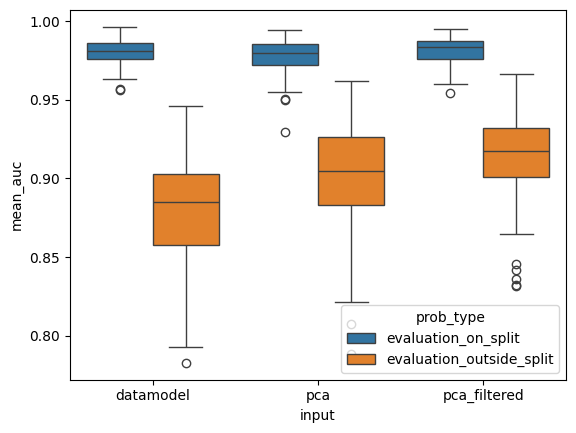

In [12]:
sns.boxplot(data=results, x='input', y='mean_auc', hue='prob_type')

18

In [28]:
import numpy as np

A = np.eye(3)
B = np.ones((2,2))
C = np.arange(6).reshape(3,2)

cf = CounterfactualInputs(alpha=A, beta=B, gamma=C)

# iterate name + matrix
for name, mat in cf:
    print(f"{name}: shape={mat.shape}")
# alpha: shape=(3, 3)
# beta:  shape=(2, 2)
# gamma: shape=(3, 2)

# length
print(len(cf))  # 3

# indexing
name, mat = cf[1]
print(name, mat)
# beta [[1. 1.]
#       [1. 1.]]

# slicing
for name, mat in cf:
    print(name)
# alpha
# beta


alpha: shape=(3, 3)
beta: shape=(2, 2)
gamma: shape=(3, 2)
3
beta [[1. 1.]
 [1. 1.]]
alpha
beta
gamma


In [21]:
# --- Spectral clustering ---
from sklearn.cluster import SpectralClustering

def get_corr_dm(weights, index):
    mat = weights[(index)][:,((index))]
    index = np.random.randint(0,mat.shape[0],500)
    corr = np.corrcoef(mat[:,index])
    corr = (corr+1)/2
    return corr

corr = get_corr_dm(weights, index_grp_2)
spectral = SpectralClustering(
    n_clusters=3,           # number of clusters you expect
    affinity='precomputed',  # or 'rbf'
    assign_labels='kmeans', # how to assign labels after embedding
    random_state=1
)
# get partitions
partitions = spectral.fit_predict(corr)

# --- Counterfactual analysis ---


In [10]:
run_counterfactual_experiment(counterfactual_estimator, 0, 10, partitions, 1)

,split,prob_type,auc,margins,seed,subcluster_index
0,split_a,evaluation_on_split,1.000000,3.204273,0,1
1,split_a,evaluation_outside_split,0.721565,1.192206,0,1
2,split_b,evaluation_on_split,0.990138,3.214584,0,1
3,split_b,evaluation_outside_split,1.000000,2.675002,0,1
0,split_a,evaluation_on_split,0.994083,3.070604,1,1
1,split_a,evaluation_outside_split,0.897436,1.268887,1,1
2,split_b,evaluation_on_split,0.979619,2.842204,1,1
3,split_b,evaluation_outside_split,0.968113,2.357297,1,1
0,split_a,evaluation_on_split,1.000000,3.118949,2,1
1,split_a,evaluation_outside_split,0.882314,1.709326,2,1


In [8]:
children = fork_rng(np.random.default_rng(0), 2)
group_to_subcluster_indices = np.invert(partitions==0)
partition = np.zeros_like(counterfactual_estimator.coarse_labels)
partition[group_to_subcluster_indices] = partitions == current_subcluster_index

run_counterfactual_experiment(counterfactual_estimator, 0, 10, partition)

NameError: name 'current_subcluster_index' is not defined

In [7]:
# --- Spectral clustering ---
from sklearn.cluster import SpectralClustering

def get_corr_dm(weights, index):
    mat = weights[(index)][:,((index))]
    index = np.random.randint(0,mat.shape[0],500)
    corr = np.corrcoef(mat[:,index])
    corr = (corr+1)/2
    return corr

corr = get_corr_dm(weights, index_grp_2)
spectral = SpectralClustering(
    n_clusters=3,           # number of clusters you expect
    affinity='precomputed',  # or 'rbf'
    assign_labels='kmeans', # how to assign labels after embedding
    random_state=1
)
# get partitions
partitions = spectral.fit_predict(corr)

# --- Counterfactual analysis ---
pc_indices = SelectPCsBasic().feature_indices(n_pcs=20)
counterfactual_estimator = CounterfactualEvaluation(features=experiment.dataset.features[:,pc_indices],
                                                        coarse_labels=np.invert(experiment.dataset.coarse_labels),
                                                        train_size=39, # corresponds to approx original model alpha of 0.012507530044163674
                                                        test_size=39,
                                                        classifier=XgbFactory(max_depth=7))

In [39]:
n_iter = 100

In [40]:
# --- Counterfactual analysis: cluster 0 ---
children = fork_rng(np.random.default_rng(0), 2)
partition = np.zeros_like(experiment.dataset.coarse_labels)
partition[index_grp_2] = partitions == 0
res_clust_0 = counterfactual_estimator.counterfactual_evaluation(partition, model_rng=children[0], shuffle_rng=children[1], n_iter=n_iter)

# --- Counterfactual analysis: cluster 1 ---
partition = np.zeros_like(experiment.dataset.coarse_labels)
partition[index_grp_2] = partitions == 1
res_clust_1 = counterfactual_estimator.counterfactual_evaluation(partition, model_rng=children[0], shuffle_rng=children[1], n_iter=n_iter)

# --- Counterfactual analysis: cluster 2 ---
partition = np.zeros_like(experiment.dataset.coarse_labels)
partition[index_grp_2] = partitions == 2
res_clust_2 = counterfactual_estimator.counterfactual_evaluation(partition, model_rng=children[0], shuffle_rng=children[1], n_iter=n_iter)

# group all results
res_clust_1['cluster'] = 1
res_clust_2['cluster'] = 2
res_clust_0['cluster'] = 0
res = pd.concat([res_clust_1, res_clust_2, res_clust_0])
res['type'] = 'datamodels'

In [41]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_scaled = scaler.fit_transform(experiment.dataset.features)
pca = PCA(n_components=500)  # adjust n_components as needed
X_pca = pca.fit_transform(X_scaled)

def get_corr_pca(weights, index):
    corr = np.corrcoef(weights[(index)])
    corr = (corr+1)/2
    return corr

corr = get_corr_pca(X_pca, index_grp_2)
spectral = SpectralClustering(
    n_clusters=3,           # number of clusters you expect
    affinity='precomputed',  # or 'rbf'
    assign_labels='kmeans', # how to assign labels after embedding
    random_state=1
)
# get partitions
partitions_pca = spectral.fit_predict(corr)

# --- Counterfactual analysis PCA: cluster 0 ---
children = fork_rng(np.random.default_rng(0), 2)
partition = np.zeros_like(experiment.dataset.coarse_labels)
partition[index_grp_2] = partitions_pca == 0
pca_res_clust_0 = counterfactual_estimator.counterfactual_evaluation(partition, model_rng=children[0], shuffle_rng=children[1], n_iter=n_iter)

# --- Counterfactual analysis PCA: cluster 1 ---
partition = np.zeros_like(experiment.dataset.coarse_labels)
partition[index_grp_2] = partitions_pca == 1
pca_res_clust_1 = counterfactual_estimator.counterfactual_evaluation(partition, model_rng=children[0], shuffle_rng=children[1], n_iter=n_iter)

# --- Counterfactual analysis PCA: cluster 2 ---
partition = np.zeros_like(experiment.dataset.coarse_labels)
partition[index_grp_2] = partitions_pca == 2
pca_res_clust_2 = counterfactual_estimator.counterfactual_evaluation(partition, model_rng=children[0], shuffle_rng=children[1], n_iter=n_iter)

# group all results
pca_res_clust_1['cluster'] = 1
pca_res_clust_2['cluster'] = 2
pca_res_clust_0['cluster'] = 0
pca_res = pd.concat([pca_res_clust_1, pca_res_clust_2, pca_res_clust_0])
pca_res['type'] = 'PCA'

In [42]:
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn import set_config
from tqdm import tqdm
from subgroups.utils.scoring import compute_margins

#set_config(display='text')

n_iter = 10
all_aucs = []
all_margins = []
for i in tqdm(range(n_iter)):
    children = fork_rng(np.random.default_rng(i), 3)

    X_tr, X_te, y_tr, y_te = train_test_split(
        experiment.dataset.features[:,pc_indices], np.invert(experiment.dataset.coarse_labels),
        train_size=0.012507530044163674,
        #stratify=np.invert(experiment.dataset.coarse_labels),        # <-- ensures y’s class distribution is preserved
        shuffle=True,
        random_state=np.random.RandomState(children[0].bit_generator)
    )

    rus = RandomUnderSampler(random_state=np.random.RandomState(children[1].bit_generator))
    X_tr_bal, y_tr_bal = rus.fit_resample(X_tr, y_tr)

    model = XgbFactory(max_depth=7).build_model(rng=np.random.default_rng(children[2]))
    model.fit(X_tr_bal, y_tr_bal)
    pred = model.predict_proba(X_te)
    auc = roc_auc_score(y_te, pred[:,1])
    margins = compute_margins(pred[:,1], y_te)
    all_aucs.append(auc)
    all_margins.append(np.mean(margins))

res_baseline = pd.DataFrame(np.hstack(all_aucs), columns = ['mean_auc'])
res_baseline['type'] = 'baseline'
res_baseline['seed'] = np.arange(len(res_baseline))
res_baseline['prob_type'] = 'not applicable'
res_baseline['mean_margins'] = np.hstack(all_margins)

100%|██████████| 10/10 [00:00<00:00, 32.94it/s]


In [43]:
def av_results(res):
    avg_auc = (
        res
        .groupby(['seed', 'prob_type', 'cluster', 'type'], as_index=False)['auc']
        .mean()
        .rename(columns={'auc': 'mean_auc'})
    )
    avg_auc = (
        avg_auc
        .groupby(['seed', 'prob_type', 'type'], as_index=False)['mean_auc']
        .mean()
    )
    return avg_auc

avg_auc = av_results(res)
avg_auc_pca = av_results(pca_res)
all_res = pd.concat([avg_auc, avg_auc_pca])

all_res = pd.concat([all_res, res_baseline])

In [44]:
all_res.index = np.arange(len(all_res))

/Users/djuna/Documents/temp/subgroups/utils/plotting.py:124: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/Users/djuna/Documents/temp/subgroups/utils/plotting.py:128: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


baseline vs. PCA: Mann-Whitney-Wilcoxon test two-sided, P_val:2.713e-07 U_stat=5.000e+00
PCA vs. datamodels: Mann-Whitney-Wilcoxon test two-sided, P_val:1.095e-01 U_stat=5.656e+03
baseline vs. datamodels: Mann-Whitney-Wilcoxon test two-sided, P_val:3.204e-07 U_stat=8.000e+00
baseline vs. PCA: Mann-Whitney-Wilcoxon test two-sided, P_val:3.310e-01 U_stat=4.060e+02
PCA vs. datamodels: Mann-Whitney-Wilcoxon test two-sided, P_val:5.957e-29 U_stat=9.570e+03


/Users/djuna/Documents/temp/subgroups/utils/plotting.py:124: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/Users/djuna/Documents/temp/subgroups/utils/plotting.py:128: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
/Users/djuna/Documents/temp/subgroups/utils/plotting.py:124: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/Users/djuna/Documents/temp/subgroups/utils/plotting.py:128: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False`

baseline vs. datamodels: Mann-Whitney-Wilcoxon test two-sided, P_val:2.064e-05 U_stat=9.100e+02
PCA vs. datamodels: Mann-Whitney-Wilcoxon test two-sided, P_val:2.003e-29 U_stat=3.900e+02


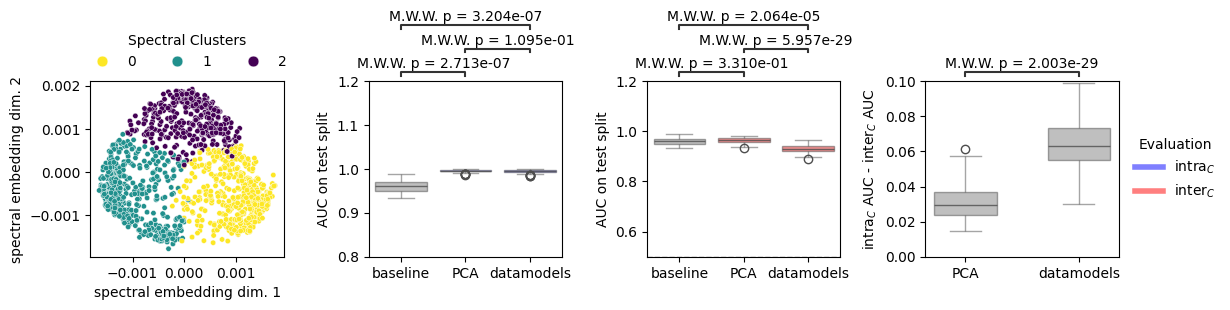

In [45]:
# plot partitions
fig, axes = plt.subplots(1, 4, figsize=(12.5, 3.5), sharey=False, sharex=False)
plot_2D_embedding(weights, index_grp_2, partitions, '', 'clusters', s=15, alpha=1, ax=axes[0])

plot_cat_continuous(
        data=all_res[all_res['prob_type']!='probabilities_outside_split'],
        cat_col='type',
        cont_col='mean_auc',
        test='Mann-Whitney',
        text_format='full',
        palette=['grey', 'blue', 'blue'],
        ax=axes[1],
        y_lower=0.8,
        y_upper=1.2,
        loc='outside',
        boxplot_kwargs={
            'boxprops':     {'alpha': 0.5},
            'whiskerprops': {'alpha': 0.5},
            'capprops':     {'alpha': 0.5},
            'medianprops':  {'alpha': 0.8},
            'width': 0.8
        },
        order = ['baseline', 'PCA', 'datamodels'],
        stripplot_kwargs={'alpha': 0.6, 'size': 0}
    )

plot_cat_continuous(
        data=all_res[all_res['prob_type']!='probabilities_on_split'],
        cat_col='type',
        cont_col='mean_auc',
        test='Mann-Whitney',
        text_format='full',
        palette=['grey', 'red', 'red'],
        ax=axes[2],
        y_lower=0.5,
        y_upper=1.2,
        boxplot_kwargs={
            'boxprops':     {'alpha': 0.5},
            'whiskerprops': {'alpha': 0.5},
            'capprops':     {'alpha': 0.5},
            'medianprops':  {'alpha': 0.8},
            'width': 0.8
        },
        order = ['baseline', 'PCA', 'datamodels'],
        stripplot_kwargs={'alpha': 0.6, 'size': 0}
    )

# plot diffs in AUC

out = []

for i in ['datamodels', 'PCA']:
    temp = all_res[all_res['type']==i]

    df_pivot = temp.pivot(index='seed', 
                        columns='prob_type', 
                        values='mean_auc')

    # compute on – out
    df_pivot['on_minus_out'] = (
        df_pivot['probabilities_on_split']
        - df_pivot['probabilities_outside_split']
    )

    result = df_pivot[['on_minus_out']].reset_index()
    result['type'] = i
    out.append(result)

out = pd.concat(out)

plot_cat_continuous(
        data=out,
        cat_col='type',
        cont_col='on_minus_out',
        test='Mann-Whitney',
        text_format='full',
        palette=['grey', 'grey'],
        ax=axes[3],
        boxplot_kwargs={
            'boxprops':     {'alpha': 0.5},
            'whiskerprops': {'alpha': 0.5},
            'capprops':     {'alpha': 0.5},
            'medianprops':  {'alpha': 0.8},
            'width': 0.55
        },
        y_lower=0,
        y_upper=0.1,
        order = ['PCA', 'datamodels'],
        stripplot_kwargs={'alpha': 0.6, 'size': 0}
    )

for ax in axes[1:]:
    ax.set_xlabel('')
    ax.set_ylabel('')

axes[1].set_ylabel('AUC')

line1, = axes[-1].plot(0, 0, lw=4, color='blue', alpha=0.5)
line2, = axes[-1].plot(0, 0, lw=4, color='red', alpha=0.5)

# now add a manual legend to just that last subplot:
axes[-1].legend(
    [line1, line2],               # the “handles”
    [r'intra$_C$', r'inter$_C$'],       # the “labels”
    loc='center left',           # anchor the legend’s center‐left
    bbox_to_anchor=(1.02, 0.5),         # position
    title='Evaluation',           # optional title
    frameon=False,                 # draw a box around it
    fontsize='medium'              # adjust text size
)

axes[1].set_ylabel('AUC on test split')
axes[2].set_ylabel('AUC on test split')
axes[3].set_ylabel(r'intra$_C$ AUC - inter$_C$ AUC')

axes[0].legend(
       # the “labels”
    title='Spectral Clusters',
    ncol=3,
    loc='lower center', 
    markerscale=2,
    frameon=False,
    bbox_to_anchor=(0.5, 1)          # adjust text size
)

axes[1].axhline(y=0.5, color='gray', linestyle='--', linewidth=1)
axes[2].axhline(y=0.5, color='gray', linestyle='--', linewidth=1)

plt.tight_layout()
#plt.savefig('/Users/djuna/Documents/Maydell-MIT-PhD-Thesis/MIT-thesis-template/ch4_figs/rosmap_aucs.png', dpi=300)


/Users/djuna/Documents/temp/subgroups/utils/plotting.py:124: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/Users/djuna/Documents/temp/subgroups/utils/plotting.py:128: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
/Users/djuna/Documents/temp/subgroups/utils/plotting.py:124: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/Users/djuna/Documents/temp/subgroups/utils/plotting.py:128: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False`

baseline vs. PCA: Mann-Whitney-Wilcoxon test two-sided, P_val:2.063e-07 U_stat=0.000e+00
PCA vs. datamodels: Mann-Whitney-Wilcoxon test two-sided, P_val:9.496e-03 U_stat=3.938e+03
baseline vs. datamodels: Mann-Whitney-Wilcoxon test two-sided, P_val:2.063e-07 U_stat=0.000e+00
baseline vs. PCA: Mann-Whitney-Wilcoxon test two-sided, P_val:2.063e-07 U_stat=0.000e+00
PCA vs. datamodels: Mann-Whitney-Wilcoxon test two-sided, P_val:2.640e-34 U_stat=9.999e+03
baseline vs. datamodels: Mann-Whitney-Wilcoxon test two-sided, P_val:6.346e-02 U_stat=6.790e+02


/Users/djuna/Documents/temp/subgroups/utils/plotting.py:124: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/Users/djuna/Documents/temp/subgroups/utils/plotting.py:128: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


PCA vs. datamodels: Mann-Whitney-Wilcoxon test two-sided, P_val:2.562e-34 U_stat=0.000e+00


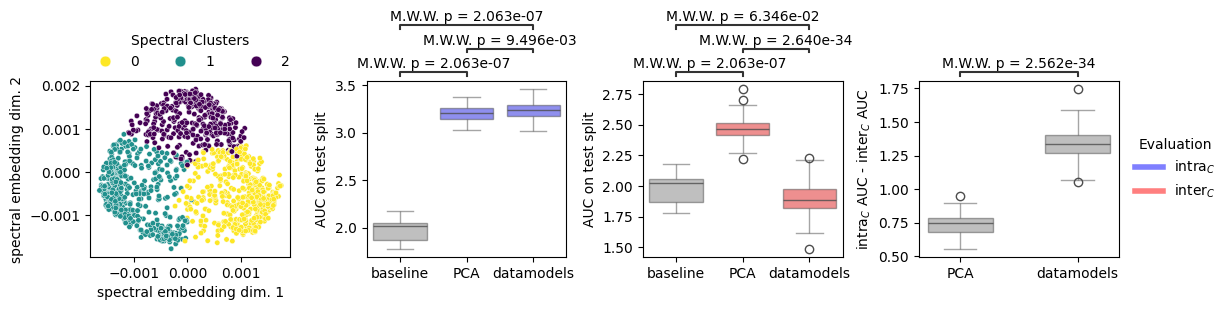

In [47]:
def av_results(res):
    avg_auc = (
        res
        .groupby(['seed', 'prob_type', 'cluster', 'type'], as_index=False)['margins']
        .mean()
        .rename(columns={'margins': 'mean_margins'})
    )
    avg_auc = (
        avg_auc
        .groupby(['seed', 'prob_type', 'type'], as_index=False)['mean_margins']
        .mean()
    )
    return avg_auc

avg_auc = av_results(res)
avg_auc_pca = av_results(pca_res)
all_res = pd.concat([avg_auc, avg_auc_pca])
all_res = pd.concat([all_res, res_baseline])
all_res.index = np.arange(len(all_res))


# plot partitions
fig, axes = plt.subplots(1, 4, figsize=(12.5, 3.5), sharey=False, sharex=False)
plot_2D_embedding(weights, index_grp_2, partitions, '', 'clusters', s=15, alpha=1, ax=axes[0])

plot_cat_continuous(
        data=all_res[all_res['prob_type']!='probabilities_outside_split'],
        cat_col='type',
        cont_col='mean_margins',
        test='Mann-Whitney',
        text_format='full',
        palette=['grey', 'blue', 'blue'],
        ax=axes[1],
        #y_lower=0.8,
       #y_upper=1.2,
        loc='outside',
        boxplot_kwargs={
            'boxprops':     {'alpha': 0.5},
            'whiskerprops': {'alpha': 0.5},
            'capprops':     {'alpha': 0.5},
            'medianprops':  {'alpha': 0.8},
            'width': 0.8
        },
        order = ['baseline', 'PCA', 'datamodels'],
        stripplot_kwargs={'alpha': 0.6, 'size': 0}
    )

plot_cat_continuous(
        data=all_res[all_res['prob_type']!='probabilities_on_split'],
        cat_col='type',
        cont_col='mean_margins',
        test='Mann-Whitney',
        text_format='full',
        palette=['grey', 'red', 'red'],
        ax=axes[2],
       # y_lower=0.5,
       # y_upper=1.2,
        boxplot_kwargs={
            'boxprops':     {'alpha': 0.5},
            'whiskerprops': {'alpha': 0.5},
            'capprops':     {'alpha': 0.5},
            'medianprops':  {'alpha': 0.8},
            'width': 0.8
        },
        order = ['baseline', 'PCA', 'datamodels'],
        stripplot_kwargs={'alpha': 0.6, 'size': 0}
    )

# plot diffs in AUC

out = []

for i in ['datamodels', 'PCA']:
    temp = all_res[all_res['type']==i]

    df_pivot = temp.pivot(index='seed', 
                        columns='prob_type', 
                        values='mean_margins')

    # compute on – out
    df_pivot['on_minus_out'] = (
        df_pivot['probabilities_on_split']
        - df_pivot['probabilities_outside_split']
    )

    result = df_pivot[['on_minus_out']].reset_index()
    result['type'] = i
    out.append(result)

out = pd.concat(out)

plot_cat_continuous(
        data=out,
        cat_col='type',
        cont_col='on_minus_out',
        test='Mann-Whitney',
        text_format='full',
        palette=['grey', 'grey'],
        ax=axes[3],
        boxplot_kwargs={
            'boxprops':     {'alpha': 0.5},
            'whiskerprops': {'alpha': 0.5},
            'capprops':     {'alpha': 0.5},
            'medianprops':  {'alpha': 0.8},
            'width': 0.55
        },
        #y_lower=0,
        #y_upper=0.1,
        order = ['PCA', 'datamodels'],
        stripplot_kwargs={'alpha': 0.6, 'size': 0}
    )

for ax in axes[1:]:
    ax.set_xlabel('')
    ax.set_ylabel('')

axes[1].set_ylabel('AUC')

line1, = axes[-1].plot(0, 0, lw=4, color='blue', alpha=0.5)
line2, = axes[-1].plot(0, 0, lw=4, color='red', alpha=0.5)

# now add a manual legend to just that last subplot:
axes[-1].legend(
    [line1, line2],               # the “handles”
    [r'intra$_C$', r'inter$_C$'],       # the “labels”
    loc='center left',           # anchor the legend’s center‐left
    bbox_to_anchor=(1.02, 0.5),         # position
    title='Evaluation',           # optional title
    frameon=False,                 # draw a box around it
    fontsize='medium'              # adjust text size
)

axes[1].set_ylabel('AUC on test split')
axes[2].set_ylabel('AUC on test split')
axes[3].set_ylabel(r'intra$_C$ AUC - inter$_C$ AUC')

axes[0].legend(
       # the “labels”
    title='Spectral Clusters',
    ncol=3,
    loc='lower center', 
    markerscale=2,
    frameon=False,
    bbox_to_anchor=(0.5, 1)          # adjust text size
)

axes[1].axhline(y=0.5, color='gray', linestyle='--', linewidth=1)
axes[2].axhline(y=0.5, color='gray', linestyle='--', linewidth=1)

plt.tight_layout()
plt.savefig('/Users/djuna/Documents/Maydell-MIT-PhD-Thesis/MIT-thesis-template/ch4_figs/gtex_margins.png', dpi=300)


In [ ]:
# need to make sure this is on the same number of features per group
# also plot the PCA results and color by subclass?